# Imports

In [193]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
import shap
import seaborn as sns
shap.initjs()


In [194]:
import numpy as np
import pandas as pd
from sklearn.metrics import explained_variance_score

pd.options.display.float_format = '{:.4f}'.format

def drop_high_correlation(X, threshold=0.95):
    # drop highly correlated features

    corr_matrix = pd.DataFrame(X).corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

    # So we are selecting the columns which are having absolute correlation greater than 0.95 and making a list of those columns named 'dropping_these_features'.
    dropping_these_features = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    X = X.drop(columns=dropping_these_features)

    return X

def drop_x_riskiest_features(df, number_to_drop=10, rolling_window=10, target_column=''):
    correlations = pd.DataFrame()
    columns = df.columns
    
    for column in columns:
        correlations[column] = df[target_column].rolling(rolling_window).corr(df[column])
    to_drop = correlations.std().sort_values(ascending=False).head(number_to_drop).keys()
    
    df.drop(columns=to_drop, inplace=True)
    return df

def get_vol(prices, span=10, delta=pd.Timedelta(days=1)):

    Delta = delta
    # 1. compute returns of the form p[t]/p[t-1] - 1
    # 1.1 find the timestamps of p[t-1] values
    df0 = prices.index.searchsorted(prices.index - delta)
    df0 = df0[df0 > 0]

    # 1.2 align timestamps of p[t-1] to timestamps of p[t]
    df0 = pd.Series(prices.index[df0-1],    
           index=prices.index[prices.shape[0]-df0.shape[0] : ])

    # 1.3 get values by timestamps, then compute returns
    df0 = prices.loc[df0.index] / prices.loc[df0.values].values - 1

    # 2. estimate rolling standard deviation
    df0 = df0.ewm(span=span).std()

    return df0

def get_barriers(daily_volatility, prices, t_final = 5, upper_lower_multipliers = [1.5, 1.5]):

    #create a container
    barriers = pd.DataFrame(columns=['datapoints_passed', 
            'price', 'vert_barrier', \
            'top_barrier', 'bottom_barrier'], \
              index = daily_volatility.index)

    for datapoint, vol in daily_volatility.iteritems():

        datapoints_passed = len(daily_volatility.loc \
                      [daily_volatility.index[0] : datapoint])

        #set the vertical barrier 
        if (datapoints_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                datapoints_passed + t_final]
        else:
            vert_barrier = np.nan

        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[datapoint] + prices.loc[datapoint] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)

        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[datapoint] - prices.loc[datapoint] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)

        barriers.loc[datapoint, ['datapoints_passed', 'price', 'vert_barrier','top_barrier', 'bottom_barrier']] = \
        datapoints_passed, prices.loc[datapoint], vert_barrier, top_barrier, bottom_barrier

    return barriers

def get_labels(barriers):
    barriers["label_barrier"] = None
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):

            # assign the initial and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]

            # assign the top and bottom barriers
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]

            #set the profit taking and stop loss conditons
            condition_pt = (barriers.price[start: end] >= \
              top_barrier).any()
            condition_sl = (barriers.price[start: end] <= \
              bottom_barrier).any()

            #assign the labels
            if condition_pt: 
                barriers['label_barrier'][i] = 1 # Top
            elif condition_sl: 
                barriers['label_barrier'][i] = 0 # Bottom  
            else: 
                barriers['label_barrier'][i] = 0.5 # time barrier

    return barriers


def SFI(featNames, split_model, training_data, train_split_index, test_split_index): 
    imp=pd.DataFrame(columns=['score'])
    for featName in featNames:
        split_model.fit(training_data.loc[train_split_index, featName].values.reshape(-1,1),
                    training_data.loc[train_split_index,
                                        ['target']].values.reshape(-1,1))
        y_pred = split_model.predict(training_data.loc[test_split_index, featName].values.reshape(-1,1))
        imp.loc[featName,'score']= explained_variance_score(training_data.loc[test_split_index, 'target'].values.reshape(-1,1), y_pred)
    return imp

In [195]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Data loading

In [196]:
#ML_FILE = "ml_trades_2024-07-24_10-48-33"
ML_FILE = "ml_trades_adj_15"
fin_ratios_file = "wrds_finratio.csv"
industry_ratios_file = "wrds_industry.csv"

In [197]:
df = pd.read_csv(f"data/{ML_FILE}.csv")
fin_ratios = pd.read_csv(f"data/{fin_ratios_file}")
industry_ratios = pd.read_csv(f"data/{industry_ratios_file}")

In [198]:
df['profit'] = df['profit'] - 2
df['profit_binary'] = df['profit'].apply(lambda x: 1 if x > 0 else 0)

In [199]:
df.profit.describe()

count   119793.0000
mean       -13.3839
std        125.0966
min       -211.9662
25%       -152.0000
50%          9.4060
75%         68.6726
max       4081.4427
Name: profit, dtype: float64

In [200]:
gics_mapping = {
    'Communication Services': 50,
    'Consumer Discretionary': 25,
    'Consumer Staples': 30,
    'Energy': 10,
    'Financials': 40,
    'Health Care': 35,
    'Industrials': 20,
    'Information Technology': 45,
    'Materials': 15,
    'Utilities': 55,
    'Real Estate': 60
}
industry_ratios['gicdesc'] = industry_ratios['gicdesc'].replace(gics_mapping)


In [201]:
last_four_columns = df.iloc[:, -4:]

# Display the selected columns
print(last_four_columns.columns.values)

['cusip' 'rv' 'exit_date' 'trade_length']


In [202]:
pd.read_csv(f'data/meta/{535555106}.csv')

,conm,gvkey,add1,add2,add3,add4,addzip,busdesc,cik,city,conml,costat,county,dlrsn,ein,fax,fic,fyrc,ggroup,gind,gsector,gsubind,idbflag,incorp,loc,naics,phone,prican,prirow,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,LINDSAY CORP,14954,"18135 Burke Street, Suite 100",NaN,NaN,NaN,68022,"Lindsay Corporation, together with its subsidi...",836157,Omaha,Lindsay Corp,A,NaN,NaN,47-0554096,402 829 6834,USA,8.0000,2010,201060,20,20106015,D,DE,USA,333111,402 829 6800,NaN,NaN,1,3523,357.0000,925.0000,B,NE,0.0000,www.lindsay.com,NaN,1988-10-12


In [203]:
# names = []
# codes = []
# for cusip in df.cusip.values:
#     try:
#         meta = pd.read_csv(f'data/meta/{cusip}.csv')
#         conm = meta.iloc[0].gvkey
#         code = meta.iloc[0].gsector
#         names.append(conm)
#         codes.append(code)
#     except:
#         names.append('Unknown')
#         codes.append('Unknown')      
# df['gvkey'] = names
# df['gsector'] = codes

In [204]:
# with open('data/names.txt', 'w') as file:
#     for name in names:
#         file.write(f"{name}\n")
        
# with open('data/codes.txt', 'w') as file:
#     for code in codes:
#         file.write(f"{code}\n")


In [205]:
with open('data/names.txt', 'r') as file:
    names = [line.strip() for line in file.readlines()]
df['gvkey'] = names
df['gvkey'] = pd.to_numeric(df['gvkey'], errors='coerce').fillna(-1).astype(int)

with open('data/codes.txt', 'r') as file:
    codes = [line.strip() for line in file.readlines()]
df['gsector'] = codes
df['gsector'] = pd.to_numeric(df['gsector'], errors='coerce').fillna(-1).astype(int)


In [206]:
cusip_to_gvkey = dict(zip(fin_ratios['cusip'], fin_ratios['gvkey']))

fin_ratios.drop(columns=['cusip'], inplace=True)


In [207]:
# Calculate the unique cusips in df and fin_ratios
unique_cusips_df = df['gvkey'].unique()
unique_cusips_fin_ratios = fin_ratios['gvkey'].unique()

# Calculate the percentage of cusips from fin_ratios that are in df
cusips_in_df_from_fin_ratios = len(set(unique_cusips_fin_ratios).intersection(unique_cusips_df))
total_unique_cusips_df = len(unique_cusips_df)

percentage_cusips_in_df_from_fin_ratios = (cusips_in_df_from_fin_ratios / total_unique_cusips_df) * 100
print(f"Percentage of gvkey from fin_ratios in df: {percentage_cusips_in_df_from_fin_ratios:.2f}%")

Percentage of gvkey from fin_ratios in df: 80.71%


In [208]:


# Convert 'date' in df to datetime format and adjust to the last day of the previous month
df['date'] = pd.to_datetime(df['date'])
df['date_day'] = df['date'] - pd.offsets.MonthBegin(1)

# Convert 'date_day' to the last day of the previous month
df['date_day'] = df['date_day'] + pd.offsets.MonthEnd(0)

# Convert 'date_day' to string format 'YYYY-MM-DD' if necessary
df['date_day'] = df['date_day'].dt.strftime('%Y-%m-%d')

# Convert 'public_date' in fin_ratios to datetime format if it is not already
fin_ratios['public_date'] = pd.to_datetime(fin_ratios['public_date']).dt.strftime('%Y-%m-%d')
industry_ratios['public_date'] = pd.to_datetime(industry_ratios['public_date']).dt.strftime('%Y-%m-%d')

# Merge the dataframes on 'date_day' and 'cusip'
df = pd.merge(df, fin_ratios, left_on=['date_day', 'gvkey'], right_on=['public_date', 'gvkey'], how='left')
df = pd.merge(df, industry_ratios, left_on=['date_day', 'gsector'], right_on=['public_date', 'gicdesc'], how='left')


In [209]:
raw = df.copy()

In [210]:
df = df.sort_values(by='date')

In [211]:
df = df[df['date'] < '2024-01-01']

In [212]:
df

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,cusip,rv,exit_date,trade_length,gvkey,gsector,date_day,permno,adate,qdate,public_date_x,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,public_date_y,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,divyield_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median
30760,2010-06-25 00:00:00+00:00,17.3300,17.3300,14.8200,14.8200,614398.0000,True,False,28.0000,30.0000,16.8345,18.2607,15.4083,-0.2062,0.1694,14980.1930,9.4000,1.9100,8599.9000,NaN,1076.7600,0.0700,2223.4800,0.0728,10143.8096,0.0624,1255.8000,0.0404,19.1050,0.0890,78.8600,0.0933,NaN,85.3100,3.1130,0.1250,1.9110,4.0710,3.9460,3.2558,0.3479,0.0000,0.0000,-0.1349,-1.0000,9.0652,16.0090,15.5511,15.2846,33.0338,13.9257,42.7162,34.4797,13.4971,35.7754,40.1231,12.7404,32.6472,1.3435,-2.1400,16.5814,NaN,18.6400,0.0200,1.0000,-12.6179,17.8705,27.7493,-213.2464,0.0000,16.0199,38.2390,54.3823,100.0000,28.5714,-71.4286,-0.1866,-0.0702,-0.0480,14.5762,16.2725,17.9688,20.8488,0.0719,0.5950,0.0543,0.1097,0.0834,0.0691,0.0641,0.0545,-0.7440,-0.1262,0.0556,-0.1660,0.0205,0.0186,-7.3646,1.4665,8.3378,-152.0000,0,92553H803,0,2010-06-28 00:00:00+00:00,1,133346,45,2010-06-30,93271.0000,2009-12-31,2010-03-31,2010-06-30,-8.4880,0.5170,7.9610,-7.5360,-7.5360,-5.6590,-5.6590,0.5340,-105.4200,NaN,-0.0930,0.1240,0.0320,0.2130,-0.0770,-0.0020,0.1160,NaN,0.0530,NaN,1.0620,-0.0400,-1.0900,0.0570,0.0360,0.1850,0.1060,0.7280,0.8610

In [213]:
df.profit.describe()

count   116802.0000
mean       -13.9338
std        125.0281
min       -211.9662
25%       -152.0000
50%          8.8250
75%         68.3682
max       4081.4427
Name: profit, dtype: float64

In [214]:
df['date'] = pd.to_datetime(df['date'], utc=True)

In [215]:
len(df[df["profit_binary"] == 1]) / len(df)

0.5277306895429873

In [216]:
len(df)

116802

In [217]:
df.head()

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,cusip,rv,exit_date,trade_length,gvkey,gsector,date_day,permno,adate,qdate,public_date_x,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,public_date_y,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,divyield_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median
30760,2010-06-25 00:00:00+00:00,17.3300,17.3300,14.8200,14.8200,614398.0000,True,False,28.0000,30.0000,16.8345,18.2607,15.4083,-0.2062,0.1694,14980.1930,9.4000,1.9100,8599.9000,NaN,1076.7600,0.0700,2223.4800,0.0728,10143.8096,0.0624,1255.8000,0.0404,19.1050,0.0890,78.8600,0.0933,NaN,85.3100,3.1130,0.1250,1.9110,4.0710,3.9460,3.2558,0.3479,0.0000,0.0000,-0.1349,-1.0000,9.0652,16.0090,15.5511,15.2846,33.0338,13.9257,42.7162,34.4797,13.4971,35.7754,40.1231,12.7404,32.6472,1.3435,-2.1400,16.5814,NaN,18.6400,0.0200,1.0000,-12.6179,17.8705,27.7493,-213.2464,0.0000,16.0199,38.2390,54.3823,100.0000,28.5714,-71.4286,-0.1866,-0.0702,-0.0480,14.5762,16.2725,17.9688,20.8488,0.0719,0.5950,0.0543,0.1097,0.0834,0.0691,0.0641,0.0545,-0.7440,-0.1262,0.0556,-0.1660,0.0205,0.0186,-7.3646,1.4665,8.3378,-152.0000,0,92553H803,0,2010-06-28 00:00:00+00:00,1,133346,45,2010-06-30,93271.0000,2009-12-31,2010-03-31,2010-06-30,-8.4880,0.5170,7.9610,-7.5360,-7.5360,-5.6590,-5.6590,0.5340,-105.4200,NaN,-0.0930,0.1240,0.0320,0.2130,-0.0770,-0.0020,0.1160,NaN,0.0530,NaN,1.0620,-0.0400,-1.0900,0.0570,0.0360,0.1850,0.1060,0.7280,0.8610

In [218]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'in_index',
       'earnings', 'from_earnings', 'to_earnings',
       ...
       'inv_turn_Median', 'pay_turn_Median', 'rect_turn_Median',
       'sale_equity_Median', 'sale_invcap_Median', 'sale_nwc_Median',
       'accrual_Median', 'rd_sale_Median', 'adv_sale_Median',
       'staff_sale_Median'],
      dtype='object', length=257)

In [219]:
#df = df.iloc[:,:-4]

In [220]:
df

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,cusip,rv,exit_date,trade_length,gvkey,gsector,date_day,permno,adate,qdate,public_date_x,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,public_date_y,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,divyield_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median
30760,2010-06-25 00:00:00+00:00,17.3300,17.3300,14.8200,14.8200,614398.0000,True,False,28.0000,30.0000,16.8345,18.2607,15.4083,-0.2062,0.1694,14980.1930,9.4000,1.9100,8599.9000,NaN,1076.7600,0.0700,2223.4800,0.0728,10143.8096,0.0624,1255.8000,0.0404,19.1050,0.0890,78.8600,0.0933,NaN,85.3100,3.1130,0.1250,1.9110,4.0710,3.9460,3.2558,0.3479,0.0000,0.0000,-0.1349,-1.0000,9.0652,16.0090,15.5511,15.2846,33.0338,13.9257,42.7162,34.4797,13.4971,35.7754,40.1231,12.7404,32.6472,1.3435,-2.1400,16.5814,NaN,18.6400,0.0200,1.0000,-12.6179,17.8705,27.7493,-213.2464,0.0000,16.0199,38.2390,54.3823,100.0000,28.5714,-71.4286,-0.1866,-0.0702,-0.0480,14.5762,16.2725,17.9688,20.8488,0.0719,0.5950,0.0543,0.1097,0.0834,0.0691,0.0641,0.0545,-0.7440,-0.1262,0.0556,-0.1660,0.0205,0.0186,-7.3646,1.4665,8.3378,-152.0000,0,92553H803,0,2010-06-28 00:00:00+00:00,1,133346,45,2010-06-30,93271.0000,2009-12-31,2010-03-31,2010-06-30,-8.4880,0.5170,7.9610,-7.5360,-7.5360,-5.6590,-5.6590,0.5340,-105.4200,NaN,-0.0930,0.1240,0.0320,0.2130,-0.0770,-0.0020,0.1160,NaN,0.0530,NaN,1.0620,-0.0400,-1.0900,0.0570,0.0360,0.1850,0.1060,0.7280,0.8610

In [221]:
df["profit"] = df["profit"] / 1000

# Data preprocessing

### Combine PSAR columns

In [222]:
df['PSAR_0.02_0.2'] = df['PSARl_0.02_0.2'].fillna(0) + df['PSARs_0.02_0.2'].fillna(0)
df.drop(columns=['PSARl_0.02_0.2', 'PSARs_0.02_0.2','log_return'], inplace=True)

### Fill NA values in columns with frequent NAs

In [223]:
df.fillna({'CryptoMarketCap':0, 'BTC': 0, 'from_earnings': 100, 'to_earnings': 100}, inplace=True)

### Check for any leftover NAs and deal with them

In [224]:
df.isnull().any().any()

True

In [225]:
df = df.fillna(0)

In [226]:
df.isnull().any().any()

False

### Convert all feature columns to float

In [227]:
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

# Print the non-numeric columns that will be dropped
non_numeric_cols.extend(last_four_columns.columns.values)
print("Non-numeric columns dropped:", non_numeric_cols)


# Remove 'date' from non-numeric columns if it exists
if 'date' in non_numeric_cols:
    non_numeric_cols.remove('date')

Non-numeric columns dropped: ['date', 'in_index', 'earnings', 'cusip', 'exit_date', 'date_day', 'adate', 'qdate', 'public_date_x', 'divyield', 'TICKER', 'public_date_y', 'divyield_Median', 'cusip', 'rv', 'exit_date', 'trade_length']


In [228]:

# Drop non-numeric columns
df = df.drop(columns=non_numeric_cols)
df = df.astype({col: 'float' for col in df.columns[1:]})

In [229]:
df.head()

,date,open,high,low,close,volume,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,gvkey,gsector,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,PSAR_0.02_0.2
30760,2010-06-25 00:00:00+00:00,17.3300,17.3300,14.8200,14.8200,614398.0000,28.0000,30.0000,16.8345,18.2607,15.4083,-0.2062,0.1694,14980.1930,9.4000,1.9100,8599.9000,0.0000,1076.7600,0.0700,2223.4800,0.0728,10143.8096,0.0624,1255.8000,0.0404,19.1050,0.0890,78.8600,0.0933,0.0000,85.3100,3.1130,0.1250,1.9110,4.0710,3.9460,3.2558,0.3479,0.0000,0.0000,-1.0000,9.0652,16.0090,15.5511,15.2846,33.0338,13.9257,42.7162,34.4797,13.4971,35.7754,40.1231,12.7404,32.6472,1.3435,-2.1400,16.5814,0.0200,1.0000,-12.6179,17.8705,27.7493,-213.2464,0.0000,16.0199,38.2390,54.3823,100.0000,28.5714,-71.4286,-0.1866,-0.0702,-0.0480,14.5762,16.2725,17.9688,20.8488,0.0719,0.5950,0.0543,0.1097,0.0834,0.0691,0.0641,0.0545,-0.7440,-0.1262,0.0556,-0.1660,0.0205,0.0186,-7.3646,1.4665,8.3378,-0.1520,0.0000,133346.0000,45.0000,93271.0000,-8.4880,0.5170,7.9610,-7.5360,-7.5360,-5.6590,-5.6590,0.5340,-105.4200,0.0000,-0.0930,0.1240,0.0320,0.2130,-0.0770,-0.0020,0.1160,0.0000,0.0530,0.0000,1.0620,-0.0400,-1.0900,0.0570,0.0360,0.1850,0.1060,0.7280,0.8610,0.7300,0.1290,0.1090,0.2530,0.1820,0.3370,0.5300,4.9100,0.1550,0.3870,0.5390,0.3360,-0.0040,0.0770,0.5390,2.3870,1.1890,0.8320,0.8070,5.0140,-0.4090,0.4880,0.6550,1.2580,1.5380,31.4000,7.6170,0.8700,5.2200,4.5600,1.4130,5.2390,5.0280,0.0020,0.0

# Create train/test split

In [230]:
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

Split dataframe to approximately 80/20 train/test. Should be disabled, if training for a live model to allow for more training data.

In [231]:
split_date = df.at[int(len(df)*0.8),"date"]
split_date = pd.to_datetime("2020-01-01", utc=True)

In [232]:
train_set = df[df['date'] < split_date]
test_set = df[df['date'] >= split_date]
#test_set = test_set[test_set['date'] < '2020-01-01']

In [233]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82771 entries, 0 to 82770
Columns: 241 entries, date to PSAR_0.02_0.2
dtypes: datetime64[ns, UTC](1), float64(240)
memory usage: 152.8 MB


In [234]:
#temp = drop_high_correlation(train_set, 0.8)
temp = train_set

In [235]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82771 entries, 0 to 82770
Columns: 241 entries, date to PSAR_0.02_0.2
dtypes: datetime64[ns, UTC](1), float64(240)
memory usage: 152.8 MB


In [236]:
temp.profit

0       -0.1520
1        0.0227
2        0.1113
3        0.0489
4       -0.1520
          ...  
82766   -0.1520
82767   -0.1520
82768    0.0336
82769   -0.1520
82770   -0.1520
Name: profit, Length: 82771, dtype: float64

In [237]:
temp.set_index('date', inplace=True)

In [238]:
#temp = drop_x_riskiest_features(temp, 30, 10, 'profit_binary')

In [239]:
columns_train = temp.columns.values

In [240]:
columns_train = [col for col in columns_train if col not in ['date', 'profit', 'profit_binary']]
columns_ia = ['open','high','low','close','volume','bb_20_2_bbmid','bb_20_2_bbupper','bb_20_2_bblower','bb_20_2_percentb','bb_20_2_bbwidth']

## Why MetaLabeling?

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116802 entries, 0 to 116801
Columns: 241 entries, date to PSAR_0.02_0.2
dtypes: datetime64[ns, UTC](1), float64(240)
memory usage: 214.8 MB


In [242]:
# Describe overall profit
overall_description = df['profit'].describe()

# Describe profits > 0
positive_description = df[df['profit_binary'] == 1]['profit'].describe()

# Describe profits < 0
negative_description = df[df['profit_binary'] == 0]['profit'].describe()

print("Overall Profit Description:\n", overall_description)
print("\nPositive Profit Description:\n", positive_description)
print("\nNegative Profit Description:\n", negative_description)

Overall Profit Description:
 count   116802.0000
mean        -0.0139
std          0.1250
min         -0.2120
25%         -0.1520
50%          0.0088
75%          0.0684
max          4.0814
Name: profit, dtype: float64

Positive Profit Description:
 count   61640.0000
mean        0.0847
std         0.0813
min         0.0000
25%         0.0339
50%         0.0644
75%         0.1109
max         4.0814
Name: profit, dtype: float64

Negative Profit Description:
 count   55162.0000
mean       -0.1242
std         0.0518
min        -0.2120
25%        -0.1520
50%        -0.1520
75%        -0.1520
max        -0.0000
Name: profit, dtype: float64


# Experiment 1: Information Advantage

In [243]:
X_train = train_set.loc[:, columns_ia]
y_train = train_set.loc[:, 'profit_binary']
y_train = y_train.astype(int)

X_test = test_set.loc[:, columns_ia]
y_test = test_set.loc[:, 'profit_binary']
y_test = y_test.astype(int)

In [244]:
cfg = {
    "num_threads": 8,
    "boosting_type": "gbdt",
    "lambda_l1": 2.8269687100646643,
    "lambda_l2": 0.1132729746179371,
    "num_leaves": 100,
    #"num_leaves": 222,
    "feature_fraction": 0.6029600980261194,
    "bagging_fraction": 0.9924346775670325,
    "bagging_freq": 2,
    "min_child_samples": 65,
    "max_depth": 14,
    "max_bin": 136,
    "learning_rate": 0.30197097330510875,
    "importance_type": "gain"
}

clf = lgb.LGBMClassifier(seed=42)

#clf.set_params(**cfg)

# clf = RandomForestClassifier(random_state=42, n_jobs=-1)
trained_clf = clf.fit(X_train, y_train)

In [245]:
ypred = trained_clf.predict(X_train)
ypred
pred_df = pd.DataFrame(data = [ypred, y_train.to_numpy()]).T
pred_df.columns = ["prediction", "target"]
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_train)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_train, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_train, y_pred))

Confusion Matrix for Direct Predictions:
[[11693 24802]
 [ 5028 41248]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.70      0.32      0.44     36495
           1       0.62      0.89      0.73     46276

    accuracy                           0.64     82771
   macro avg       0.66      0.61      0.59     82771
weighted avg       0.66      0.64      0.60     82771



In [246]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_train)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.8).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_train, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_train, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[36495     0]
 [46275     1]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.44      1.00      0.61     36495
           1       1.00      0.00      0.00     46276

    accuracy                           0.44     82771
   macro avg       0.72      0.50      0.31     82771
weighted avg       0.75      0.44      0.27     82771



In [247]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X_train is a DataFrame containing your training features
X_train = pd.DataFrame(X_train)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Display the VIF data
print(vif_data)


            feature        VIF
0              open  2588.5208
1              high  5586.0375
2               low  6095.9945
3             close 15702.5868
4            volume     1.0914
5     bb_20_2_bbmid        inf
6   bb_20_2_bbupper        inf
7   bb_20_2_bblower        inf
8  bb_20_2_percentb     1.6871
9   bb_20_2_bbwidth     1.7057


divide by zero encountered in double_scalars


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


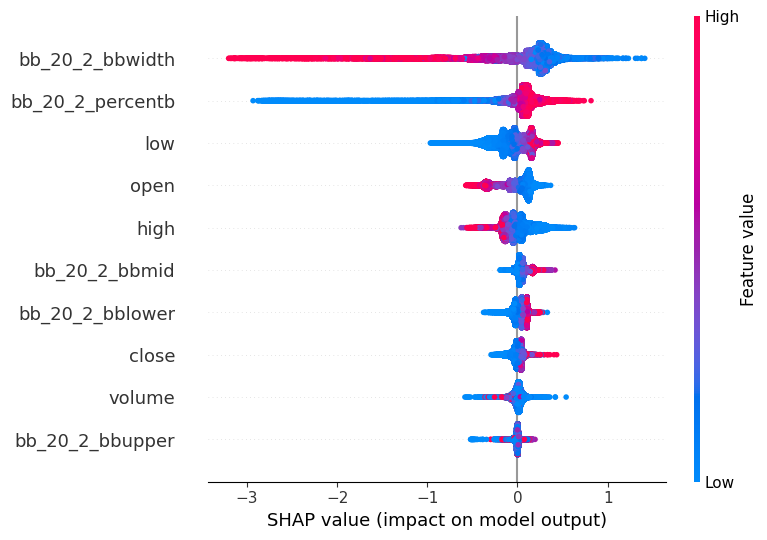

In [248]:
# Create SHAP explainer
explainer = shap.TreeExplainer(trained_clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot for the first class (if binary classification)
shap.summary_plot(shap_values[1], X_train)

In [249]:
# Results Primary

primary_forecast = pd.DataFrame(y_test)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18667
           1       0.45      1.00      0.62     15364

    accuracy                           0.45     34031
   macro avg       0.23      0.50      0.31     34031
weighted avg       0.20      0.45      0.28     34031

Confusion Matrix
[[    0 18667]
 [    0 15364]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [250]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_test)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_test, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_test, y_pred))

Confusion Matrix for Direct Predictions:
[[ 8261 10406]
 [ 3438 11926]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.71      0.44      0.54     18667
           1       0.53      0.78      0.63     15364

    accuracy                           0.59     34031
   macro avg       0.62      0.61      0.59     34031
weighted avg       0.63      0.59      0.58     34031



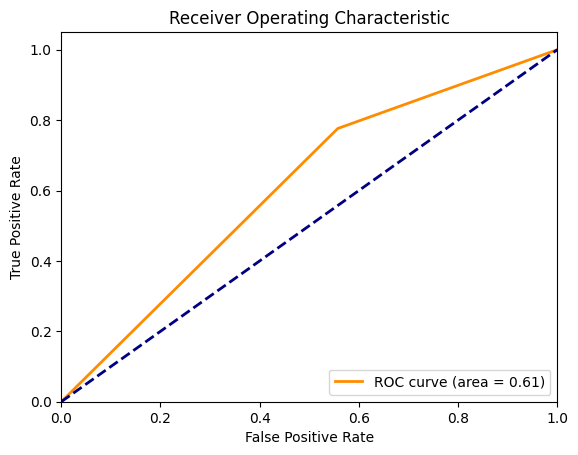

In [251]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [252]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.6).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_test, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[13031  5636]
 [ 8370  6994]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.61      0.70      0.65     18667
           1       0.55      0.46      0.50     15364

    accuracy                           0.59     34031
   macro avg       0.58      0.58      0.58     34031
weighted avg       0.58      0.59      0.58     34031



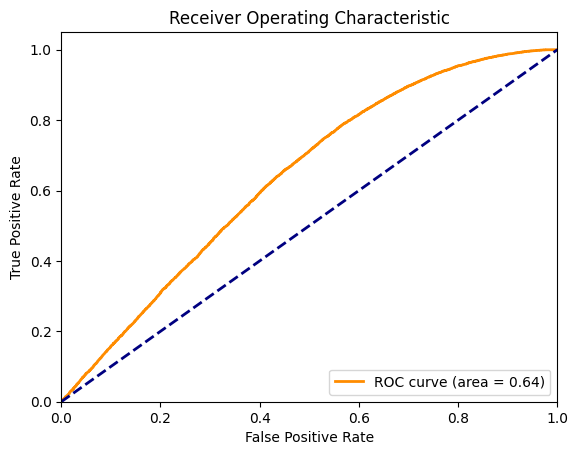

In [253]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Model Performance Changes
      Metric  Primary Model  Secondary Model  Change (%)
0  Precision         0.4515           0.5538     22.6571
1     Recall         1.0000           0.4552    -54.4780
2   F1-Score         0.6221           0.4997    -19.6771
3   Accuracy         0.4515           0.5884     30.3372
4        AUC         0.5000           0.6389     27.7724


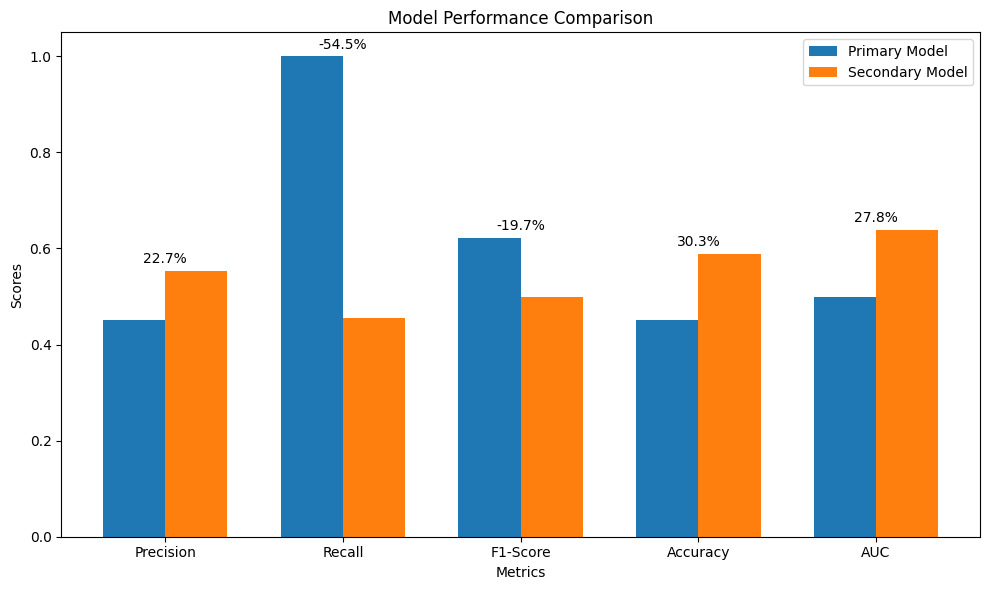

In [254]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
primary_forecast = pd.DataFrame(y_test)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Secondary model predictions
# Assuming clf and X_test are defined elsewhere
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred_threshold = (y_pred_proba >= 0.6).astype(int)

# Calculate performance metrics for primary model
precision_primary, recall_primary, f1_primary, _ = precision_recall_fscore_support(primary_forecast['actual'], primary_forecast['pred'], average=None, labels=[1])
accuracy_primary = accuracy_score(primary_forecast['actual'], primary_forecast['pred'])
# For the primary model, since the prediction is always 1, the AUC is not applicable
auc_primary = roc_auc_score(primary_forecast['actual'], primary_forecast['pred'])

# Calculate performance metrics for secondary model
precision_secondary, recall_secondary, f1_secondary, _ = precision_recall_fscore_support(y_test, y_pred_threshold, average=None, labels=[1])
accuracy_secondary = accuracy_score(y_test, y_pred_threshold)
auc_secondary = roc_auc_score(y_test, y_pred_proba)  # Use probabilities for AUC calculation

# Calculate percentage changes
precision_change = ((precision_secondary - precision_primary) / precision_primary) * 100
recall_change = ((recall_secondary - recall_primary) / recall_primary) * 100
f1_change = ((f1_secondary - f1_primary) / f1_primary) * 100
accuracy_change = ((accuracy_secondary - accuracy_primary) / accuracy_primary) * 100
auc_change = ((auc_secondary - auc_primary) / auc_primary) * 100 if auc_primary != 0 else 0

# Create a DataFrame for the changes
changes_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'AUC'],
    'Primary Model': [precision_primary[0], recall_primary[0], f1_primary[0], accuracy_primary, auc_primary],
    'Secondary Model': [precision_secondary[0], recall_secondary[0], f1_secondary[0], accuracy_secondary, auc_secondary],
    'Change (%)': [precision_change[0], recall_change[0], f1_change[0], accuracy_change, auc_change]
})

# Print the DataFrame to the console
print("Model Performance Changes")
print(changes_df)

# Plotting the changes
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(changes_df))

bar1 = ax.bar(index, changes_df['Primary Model'], bar_width, label='Primary Model')
bar2 = ax.bar(index + bar_width, changes_df['Secondary Model'], bar_width, label='Secondary Model')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(changes_df['Metric'])
ax.legend()

# Adding percentage change annotations
for i in range(len(changes_df)):
    ax.text(i + bar_width / 2, max(changes_df['Primary Model'][i], changes_df['Secondary Model'][i]) + 0.01,
            f"{changes_df['Change (%)'][i]:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Financials

In [255]:
import numpy as np
import pandas as pd

ypred = trained_clf.predict_proba(X_test)[:,1]
column_names = test_set.columns.to_list()
column_names.append("pred")
test_set_with_preds = pd.DataFrame(data = np.c_[test_set.to_numpy(), ypred])
test_set_with_preds.columns = column_names

# Assuming `test_set_with_preds` DataFrame is already created as shown in your context

# Primary Model: Predictions are all 1
primary_model_profits = test_set_with_preds["profit"]

# Secondary Model: Predictions with a threshold of 0.6
secondary_model_profits = test_set_with_preds[test_set_with_preds["pred"] > 0.6]["profit"]

# Calculate mean and standard deviation for primary model
primary_mean_profit = primary_model_profits.mean()
primary_std_profit = primary_model_profits.std()

# Calculate mean and standard deviation for secondary model
secondary_mean_profit = secondary_model_profits.mean()
secondary_std_profit = secondary_model_profits.std()

# Calculate the differences
mean_profit_difference = secondary_mean_profit - primary_mean_profit
std_profit_difference = secondary_std_profit - primary_std_profit

# Print the results
print("Mean Profit Difference (Secondary - Primary):", mean_profit_difference)
print("Standard Deviation of Profit Difference (Secondary - Primary):", std_profit_difference)


Mean Profit Difference (Secondary - Primary): 0.013393072758088579
Standard Deviation of Profit Difference (Secondary - Primary): -0.03547803902964351


In [256]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Define function to calculate daily returns
def calculate_daily_returns(prices):
    return prices['prccd'].pct_change().fillna(0)

# Define function to calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    if len(returns) > 1:  # Ensure there are enough returns to calculate statistics
        excess_returns = returns - risk_free_rate
        return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    else:
        return np.nan  # Return NaN if not enough data

# Define function to calculate maximum drawdown
def calculate_max_drawdown(returns):
    if len(returns) > 1:
        cumulative_returns = (1 + returns).cumprod()
        running_max = cumulative_returns.cummax()
        drawdowns = (running_max - cumulative_returns) / running_max
        return drawdowns.max()
    else:
        return np.nan

# Define function to calculate annualized returns
def calculate_annualized_returns(returns):
    if len(returns) > 1:
        cumulative_return = (1 + returns).prod()
        return cumulative_return ** (252 / len(returns)) - 1
    else:
        return np.nan

# Define function to calculate annualized standard deviation
def calculate_annualized_stdev(returns):
    if len(returns) > 1:
        return np.std(returns) * np.sqrt(252)
    else:
        return np.nan

# Merge test_set_with_preds with raw to include 'cusip' and 'exit_date'
merged_trades = pd.merge(
    test_set_with_preds,
    raw[['date', 'exit_date', 'gvkey', 'cusip']],
    on=['date', 'gvkey'],
    how='left'
)

# Determine the overall date range from the entire test_set_with_preds
overall_start_date = merged_trades['date'].min()
overall_end_date = merged_trades['exit_date'].max()

# Initialize lists to store the metrics for boxplots
metrics_primary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}
metrics_secondary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}

# Iterate over each asset in the merged trades
for asset, group in merged_trades.groupby(['gvkey', 'cusip']):
    cusip = group['cusip'].iloc[0]

    # Load daily price data for the asset
    price_data_path = f"data/trading_daily/{cusip}.csv"
    if os.path.exists(price_data_path):
        price_data = pd.read_csv(price_data_path, parse_dates=['datadate'])
        price_data.set_index('datadate', inplace=True)

        # Calculate daily returns
        price_data['daily_return'] = calculate_daily_returns(price_data)

        # Filter trade periods beforehand for the primary strategy
        primary_trade_dates = pd.DatetimeIndex([])
        for _, trade in group.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            primary_trade_dates = primary_trade_dates.append(trade_dates)

        # Filtered returns for primary strategy
        primary_trade_returns = price_data.loc[primary_trade_dates, 'daily_return']

        # Calculate metrics for the primary strategy if trades occurred
        if not primary_trade_returns.empty:
            metrics_primary['Sharpe Ratio'].append(calculate_sharpe_ratio(primary_trade_returns))
            metrics_primary['Max Drawdown'].append(calculate_max_drawdown(primary_trade_returns))
            metrics_primary['Annualized Return'].append(calculate_annualized_returns(primary_trade_returns))
            metrics_primary['Annualized Stdev'].append(calculate_annualized_stdev(primary_trade_returns))

        # Filter trade periods beforehand for the secondary strategy
        secondary_trades = group[group['pred'] > 0.6]
        secondary_trade_dates = pd.DatetimeIndex([])
        for _, trade in secondary_trades.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            secondary_trade_dates = secondary_trade_dates.append(trade_dates)

        # Filtered returns for secondary strategy
        secondary_trade_returns = price_data.loc[secondary_trade_dates, 'daily_return']

        # Calculate metrics for the secondary strategy if trades occurred
        if not secondary_trade_returns.empty:
            metrics_secondary['Sharpe Ratio'].append(calculate_sharpe_ratio(secondary_trade_returns))
            metrics_secondary['Max Drawdown'].append(calculate_max_drawdown(secondary_trade_returns))
            metrics_secondary['Annualized Return'].append(calculate_annualized_returns(secondary_trade_returns))
            metrics_secondary['Annualized Stdev'].append(calculate_annualized_stdev(secondary_trade_returns))

# Convert NaN values to 0 for plotting
for metric in metrics_primary:
    metrics_primary[metric] = np.nan_to_num(metrics_primary[metric], nan=0.0)

for metric in metrics_secondary:
    metrics_secondary[metric] = np.nan_to_num(metrics_secondary[metric], nan=0.0)

# Plotting boxplots for each metric
metrics = ['Sharpe Ratio', 'Max Drawdown', 'Annualized Return', 'Annualized Stdev']




In [257]:
def winsorize(series, lower_quantile=0.10, upper_quantile=0.90):
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower=lower_bound, upper=upper_bound)

# Apply Winsorization
for metric in metrics_primary:
    metrics_primary[metric] = winsorize(pd.Series(metrics_primary[metric]))
for metric in metrics_secondary:
    metrics_secondary[metric] = winsorize(pd.Series(metrics_secondary[metric]))


# Convert the metrics dictionaries to DataFrames
primary_metrics_df = pd.DataFrame(metrics_primary)
secondary_metrics_df = pd.DataFrame(metrics_secondary)

# Output descriptive statistics
print("Primary Metrics Descriptive Statistics:")
print(primary_metrics_df.describe())

print("\nSecondary Metrics Descriptive Statistics:")
print(secondary_metrics_df.describe())

Primary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     3975.0000     3975.0000          3975.0000         3975.0000
mean        -1.6072        0.4334            -0.4663            0.5012
std          1.6382        0.1670             0.3446            0.2039
min         -5.0316        0.1862            -0.9868            0.2527
25%         -2.4323        0.2945            -0.7944            0.3278
50%         -1.1629        0.4240            -0.4175            0.4483
75%         -0.3790        0.5727            -0.1777            0.6547
max          0.3058        0.6997             0.0302            0.8775

Secondary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     2892.0000     2892.0000          2892.0000         2892.0000
mean        -1.0358        0.2225            -0.1993            0.3426
std          1.9688        0.1049             0.4738            0

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


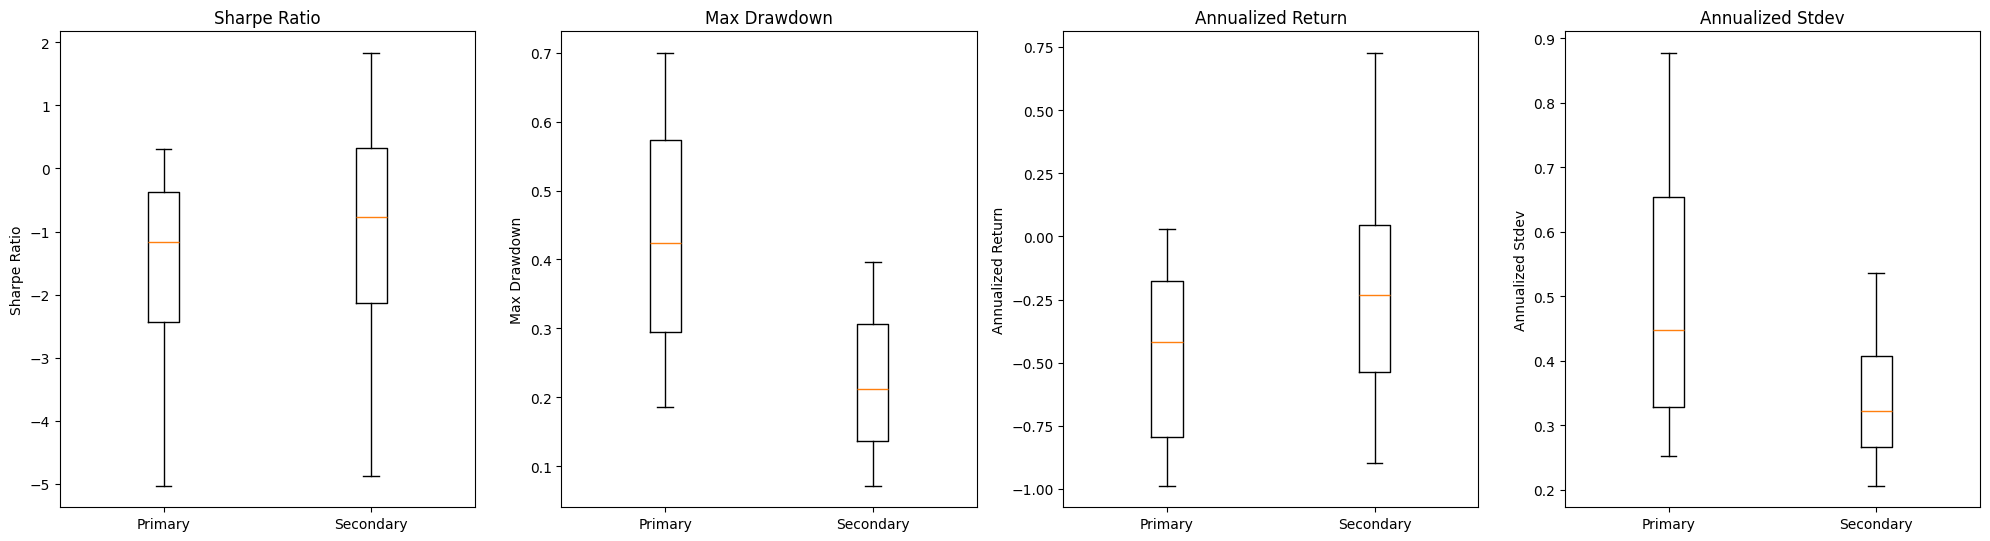

In [258]:


fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.boxplot([metrics_primary[metric], metrics_secondary[metric]], labels=['Primary', 'Secondary'])
    ax.set_title(metric)
    ax.set_ylabel(metric)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Experiment 2: False Negatives

In [259]:
# columns_train = [ 'indret_vw', 'ptb',
#        'frac_diff_close', 'CrudeOil_Vol', 'bm', 'indret_ew', 'Silver_Daily_Vol',
#         'NASDAQ_Vol', 'to_earnings', 'std', 'Gold', 'HMA_2', 'Silver', 'Treasury_Yield4', 'USDIndex', 'z_score',
#        'max_ret', 'NATR_4', 'STDEV_1', 'garch_vol_close', 
#        'from_earnings', 'Gold_Daily_Vol', 'treasury_yield1_vol', 'open','high','low','close','volume','bb_20_2_bbmid','bb_20_2_bbupper','bb_20_2_bblower','bb_20_2_percentb','bb_20_2_bbwidth']

columns_train = ['indret_vw', 'ptb', 'frac_diff_close', 'CrudeOil_Vol', 'bm', 'indret_ew',
 'NASDAQ_Vol',  'HMA_2', 'z_score',  'NATR_4',
 'from_earnings', 'Gold_Daily_Vol', 'treasury_yield1_vol',  'bb_20_2_bbwidth']


In [260]:
X_train = train_set.loc[:, columns_train]

y_train = train_set.loc[:, 'profit_binary']
y_train = y_train.astype(int)


In [261]:
X_test = test_set.loc[:, columns_train]
y_test = test_set.loc[:, 'profit_binary']
y_test = y_test.astype(int)

In [262]:
y_train.value_counts()

1    46276
0    36495
Name: profit_binary, dtype: int64

In [263]:
# Replace -inf and inf in X_train
X_train = X_train.replace([np.inf, -np.inf], np.nan)  # Temporarily replace inf and -inf with NaN
max_value_train = X_train.max().max()  # Find the maximum finite value
min_value_train = X_train.min().min()  # Find the minimum finite value

X_train = X_train.fillna(max_value_train).replace(-np.inf, min_value_train)  # Replace NaN with max value and -inf with min value

# Replace -inf and inf in X_test
X_test = X_test.replace([np.inf, -np.inf], np.nan)  # Temporarily replace inf and -inf with NaN
max_value_test = X_test.max().max()  # Find the maximum finite value
min_value_test = X_test.min().min()  # Find the minimum finite value

X_test = X_test.fillna(max_value_test).replace(-np.inf, min_value_test)  # Replace NaN with max value and -inf with min value


In [264]:
X_test.describe()

,indret_vw,ptb,frac_diff_close,CrudeOil_Vol,bm,indret_ew,NASDAQ_Vol,HMA_2,z_score,NATR_4,from_earnings,Gold_Daily_Vol,treasury_yield1_vol,bb_20_2_bbwidth
count,34031.0000,34031.0000,34031.0000,34031.0000,34031.0000,34031.0000,34031.0000,34031.0000,34031.0000,34031.0000,34031.0000,34031.0000,34031.0000,34031.0000
mean,-0.0198,3.7174,5.6075,0.2185,0.3956,-0.0286,0.0631,-0.0604,-2.4344,5.0433,34.5451,0.0409,0.4666,0.1364
std,0.0575,7.6691,267.5883,0.1043,0.5078,0.0703,0.0266,0.0895,242.6732,5.4017,27.1973,0.0119,0.2566,0.0954
min,-0.3710,0.0000,-1764.5656,0.0696,0.0000,-0.4462,0.0219,-3.9099,-458.1359,0.1369,0.0000,0.0176,0.0757,0.0020
25%,-0.0539,0.2380,-0.0589,0.1505,0.0070,-0.0719,0.0436,-0.0732,-4.1386,2.7233,15.0000,0.0335,0.2614,0.0736
50%,-0.0159,1.5790,0.9367,0.2035,0.2580,-0.0256,0.0616,-0.0416,-3.1340,4.0041,31.0000,0.0393,0.4380,0.1123
75%,0.0110,3.6475,3.4101,0.2554,0.5990,0.0020,0.0777,-0.0217,-2.4979,6.1180,49.0000,0.0457,0.6091,0.1713
max,0.3253,99.6690,44757.7709,1.3794,17.6690,0.5725,0.2691,0.7059,44757.7709,469.3838,556.0000,0.1243,1.5481,1.2620


### Train Meta Model

In [265]:
from sklearn.ensemble import RandomForestClassifier
cfg = {
    "num_threads": 8,
    "boosting_type": "gbdt",
    "lambda_l1": 2.8269687100646643,
    "lambda_l2": 0.1132729746179371,
    "num_leaves": 100,
    #"num_leaves": 222,
    "feature_fraction": 0.6029600980261194,
    "bagging_fraction": 0.9924346775670325,
    "bagging_freq": 2,
    "min_child_samples": 65,
    "max_depth": 14,
    "max_bin": 136,
    "learning_rate": 0.30197097330510875,
    "importance_type": "gain"
}

clf = lgb.LGBMClassifier(seed=42)

clf.set_params(**cfg)

# clf = RandomForestClassifier(random_state=42, n_jobs=-1)
trained_clf = clf.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.1132729746179371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1132729746179371
[LightGBM] [Warning] feature_fraction is set=0.6029600980261194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029600980261194
[LightGBM] [Warning] bagging_fraction is set=0.9924346775670325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9924346775670325
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] lambda_l1 is set=2.8269687100646643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8269687100646643


In [266]:
X_train

,indret_vw,ptb,frac_diff_close,CrudeOil_Vol,bm,indret_ew,NASDAQ_Vol,HMA_2,z_score,NATR_4,from_earnings,Gold_Daily_Vol,treasury_yield1_vol,bb_20_2_bbwidth
date,,,,,,,,,,,,,,
2010-06-25 00:00:00+00:00,-0.0618,1.3310,8.3378,0.0933,0.5170,-0.0642,0.0728,-0.1866,-7.3646,9.0652,28.0000,0.0404,0.3479,0.1694
2010-06-25 00:00:00+00:00,-0.1022,2.0060,1.5356,0.0933,0.4130,-0.1168,0.0728,0.0164,-1.9091,2.9096,30.0000,0.0404,0.3479,0.1236
2010-06-25 00:00:00+00:00,-0.0694,0.8200,0.3295,0.0933,0.8730,-0.0736,0.0728,-0.0162,-2.5418,6.7840,53.0000,0.0404,0.3479,0.1366
2010-06-25 00:00:00+00:00,-0.0798,1.7500,-0.0674,0.0933,0.4990,-0.1002,0.0728,-0.0531,-2.7503,5.3392,34.0000,0.0404,0.3479,0.1805
2010-06-25 00:00:00+00:00,-0.1022,2.1490,1.3352,0.0933,0.4050,-0.1168,0.0728,-0.0183,-1.9559,3.5956,40.0000,0.0404,0.3479,0.1688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 00:00:00+00:00,0.0000,0.0000,-2.5697,0.0937,0.0000,0.0000,0.0209,-0.0551,-2.3854,12.6995,36.0000,0.0231,0.2701,0.2731
2019-12-31 00:00:00+00:00,0.0212,3.7030,0.7687,0.0937,0.2690,0.0273,0.0209,-0.0131,-2.6680,1.5458,41.0000,0.0231,0.2701,0.0497
2019-12-31 00:00:00+00:00,0.0007,1.9850,0.4805,0.0937,0.5530,0.0347,0.0209,-0.0185,-2.1570,1.8775,37.0000,0.0231,0.2701,0.0333


In [267]:
ypred = trained_clf.predict(X_train)
ypred
pred_df = pd.DataFrame(data = [ypred, y_train.to_numpy()]).T
pred_df.columns = ["prediction", "target"]
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_train)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_train, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_train, y_pred))

Confusion Matrix for Direct Predictions:
[[26733  9762]
 [ 5094 41182]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78     36495
           1       0.81      0.89      0.85     46276

    accuracy                           0.82     82771
   macro avg       0.82      0.81      0.81     82771
weighted avg       0.82      0.82      0.82     82771



In [268]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_train)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.8).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_train, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_train, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[35800   695]
 [27936 18340]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.56      0.98      0.71     36495
           1       0.96      0.40      0.56     46276

    accuracy                           0.65     82771
   macro avg       0.76      0.69      0.64     82771
weighted avg       0.79      0.65      0.63     82771



import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

# Assuming `trained_clf` is your trained model and `X_train` is your training data

# Gain-based feature importance
gain_importance = trained_clf.booster_.feature_importance(importance_type='gain')
gain_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': gain_importance})
print("Gain-based feature importance:\n", gain_importance_df)

# Split-based feature importance
split_importance = trained_clf.booster_.feature_importance(importance_type='split')
split_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': split_importance})
print("Split-based feature importance:\n", split_importance_df)

# Permutation importance (optional and more computationally expensive)
perm_importance = permutation_importance(trained_clf, X_train, y_train, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importance.importances_mean})
print("Permutation feature importance:\n", perm_importance_df)

# Plotting feature importance (optional)
import matplotlib.pyplot as plt

# Plot gain-based feature importance
gain_importance_df = gain_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(gain_importance_df['feature'], gain_importance_df['importance'])
plt.xlabel('Gain Importance')
plt.ylabel('Features')
plt.title('Feature Importance by Gain')
plt.gca().invert_yaxis()
plt.show()

# Plot split-based feature importance
split_importance_df = split_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(split_importance_df['feature'], split_importance_df['importance'])
plt.xlabel('Split Importance')
plt.ylabel('Features')
plt.title('Feature Importance by Split')
plt.gca().invert_yaxis()
plt.show()


# Get top 20 features by Gain-based importance
top20_gain = gain_importance_df.sort_values(by='importance', ascending=False).head(50)
print("Top 20 features by Gain-based importance:\n", top20_gain)

# Get top 20 features by Split-based importance
top20_split = split_importance_df.sort_values(by='importance', ascending=False).head(50)
print("Top 20 features by Split-based importance:\n", top20_split)

# Get top 20 features by Permutation importance
top20_perm = perm_importance_df.sort_values(by='importance', ascending=False).head(50)
print("Top 20 features by Permutation importance:\n", top20_perm)

# Find the common top 20 features across all methods
common_top20_features = set(top20_gain['feature']).intersection(top20_split['feature'], top20_perm['feature'])
print("Top 20 features that scored well in all methods:\n", common_top20_features)

# Convert common top 20 features to DataFrame for display
common_top20_features_df = pd.DataFrame(common_top20_features, columns=['feature'])
print("Common top 20 features across all methods:\n", common_top20_features_df)


In [269]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Define function to calculate daily returns
def calculate_daily_returns(prices):
    return prices['prccd'].pct_change().fillna(0)

# Define function to calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    if len(returns) > 1:  # Ensure there are enough returns to calculate statistics
        excess_returns = returns - risk_free_rate
        return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    else:
        return np.nan  # Return NaN if not enough data

# Define function to calculate maximum drawdown
def calculate_max_drawdown(returns):
    if len(returns) > 1:
        cumulative_returns = (1 + returns).cumprod()
        running_max = cumulative_returns.cummax()
        drawdowns = (running_max - cumulative_returns) / running_max
        return drawdowns.max()
    else:
        return np.nan

# Define function to calculate annualized returns
def calculate_annualized_returns(returns):
    if len(returns) > 1:
        cumulative_return = (1 + returns).prod()
        return cumulative_return ** (252 / len(returns)) - 1
    else:
        return np.nan

# Define function to calculate annualized standard deviation
def calculate_annualized_stdev(returns):
    if len(returns) > 1:
        return np.std(returns) * np.sqrt(252)
    else:
        return np.nan

# Merge test_set_with_preds with raw to include 'cusip' and 'exit_date'
merged_trades = pd.merge(
    test_set_with_preds,
    raw[['date', 'exit_date', 'gvkey', 'cusip']],
    on=['date', 'gvkey'],
    how='left'
)

# Determine the overall date range from the entire test_set_with_preds
overall_start_date = merged_trades['date'].min()
overall_end_date = merged_trades['exit_date'].max()

# Initialize lists to store the metrics for boxplots
metrics_primary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}
metrics_secondary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}

# Iterate over each asset in the merged trades
for asset, group in merged_trades.groupby(['gvkey', 'cusip']):
    cusip = group['cusip'].iloc[0]

    # Load daily price data for the asset
    price_data_path = f"data/trading_daily/{cusip}.csv"
    if os.path.exists(price_data_path):
        price_data = pd.read_csv(price_data_path, parse_dates=['datadate'])
        price_data.set_index('datadate', inplace=True)

        # Calculate daily returns
        price_data['daily_return'] = calculate_daily_returns(price_data)

        # Filter trade periods beforehand for the primary strategy
        primary_trade_dates = pd.DatetimeIndex([])
        for _, trade in group.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            primary_trade_dates = primary_trade_dates.append(trade_dates)

        # Filtered returns for primary strategy
        primary_trade_returns = price_data.loc[primary_trade_dates, 'daily_return']

        # Calculate metrics for the primary strategy if trades occurred
        if not primary_trade_returns.empty:
            metrics_primary['Sharpe Ratio'].append(calculate_sharpe_ratio(primary_trade_returns))
            metrics_primary['Max Drawdown'].append(calculate_max_drawdown(primary_trade_returns))
            metrics_primary['Annualized Return'].append(calculate_annualized_returns(primary_trade_returns))
            metrics_primary['Annualized Stdev'].append(calculate_annualized_stdev(primary_trade_returns))

        # Filter trade periods beforehand for the secondary strategy
        secondary_trades = group[group['pred'] > 0.6]
        secondary_trade_dates = pd.DatetimeIndex([])
        for _, trade in secondary_trades.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            secondary_trade_dates = secondary_trade_dates.append(trade_dates)

        # Filtered returns for secondary strategy
        secondary_trade_returns = price_data.loc[secondary_trade_dates, 'daily_return']

        # Calculate metrics for the secondary strategy if trades occurred
        if not secondary_trade_returns.empty:
            metrics_secondary['Sharpe Ratio'].append(calculate_sharpe_ratio(secondary_trade_returns))
            metrics_secondary['Max Drawdown'].append(calculate_max_drawdown(secondary_trade_returns))
            metrics_secondary['Annualized Return'].append(calculate_annualized_returns(secondary_trade_returns))
            metrics_secondary['Annualized Stdev'].append(calculate_annualized_stdev(secondary_trade_returns))

# Convert NaN values to 0 for plotting
for metric in metrics_primary:
    metrics_primary[metric] = np.nan_to_num(metrics_primary[metric], nan=0.0)

for metric in metrics_secondary:
    metrics_secondary[metric] = np.nan_to_num(metrics_secondary[metric], nan=0.0)

# Plotting boxplots for each metric
metrics = ['Sharpe Ratio', 'Max Drawdown', 'Annualized Return', 'Annualized Stdev']




In [270]:
def winsorize(series, lower_quantile=0.10, upper_quantile=0.90):
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower=lower_bound, upper=upper_bound)

# Apply Winsorization
for metric in metrics_primary:
    metrics_primary[metric] = winsorize(pd.Series(metrics_primary[metric]))
for metric in metrics_secondary:
    metrics_secondary[metric] = winsorize(pd.Series(metrics_secondary[metric]))


# Convert the metrics dictionaries to DataFrames
primary_metrics_df = pd.DataFrame(metrics_primary)
secondary_metrics_df = pd.DataFrame(metrics_secondary)

# Output descriptive statistics
print("Primary Metrics Descriptive Statistics:")
print(primary_metrics_df.describe())

print("\nSecondary Metrics Descriptive Statistics:")
print(secondary_metrics_df.describe())

Primary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     3975.0000     3975.0000          3975.0000         3975.0000
mean        -1.6072        0.4334            -0.4663            0.5012
std          1.6382        0.1670             0.3446            0.2039
min         -5.0316        0.1862            -0.9868            0.2527
25%         -2.4323        0.2945            -0.7944            0.3278
50%         -1.1629        0.4240            -0.4175            0.4483
75%         -0.3790        0.5727            -0.1777            0.6547
max          0.3058        0.6997             0.0302            0.8775

Secondary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     2892.0000     2892.0000          2892.0000         2892.0000
mean        -1.0358        0.2225            -0.1993            0.3426
std          1.9688        0.1049             0.4738            0

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


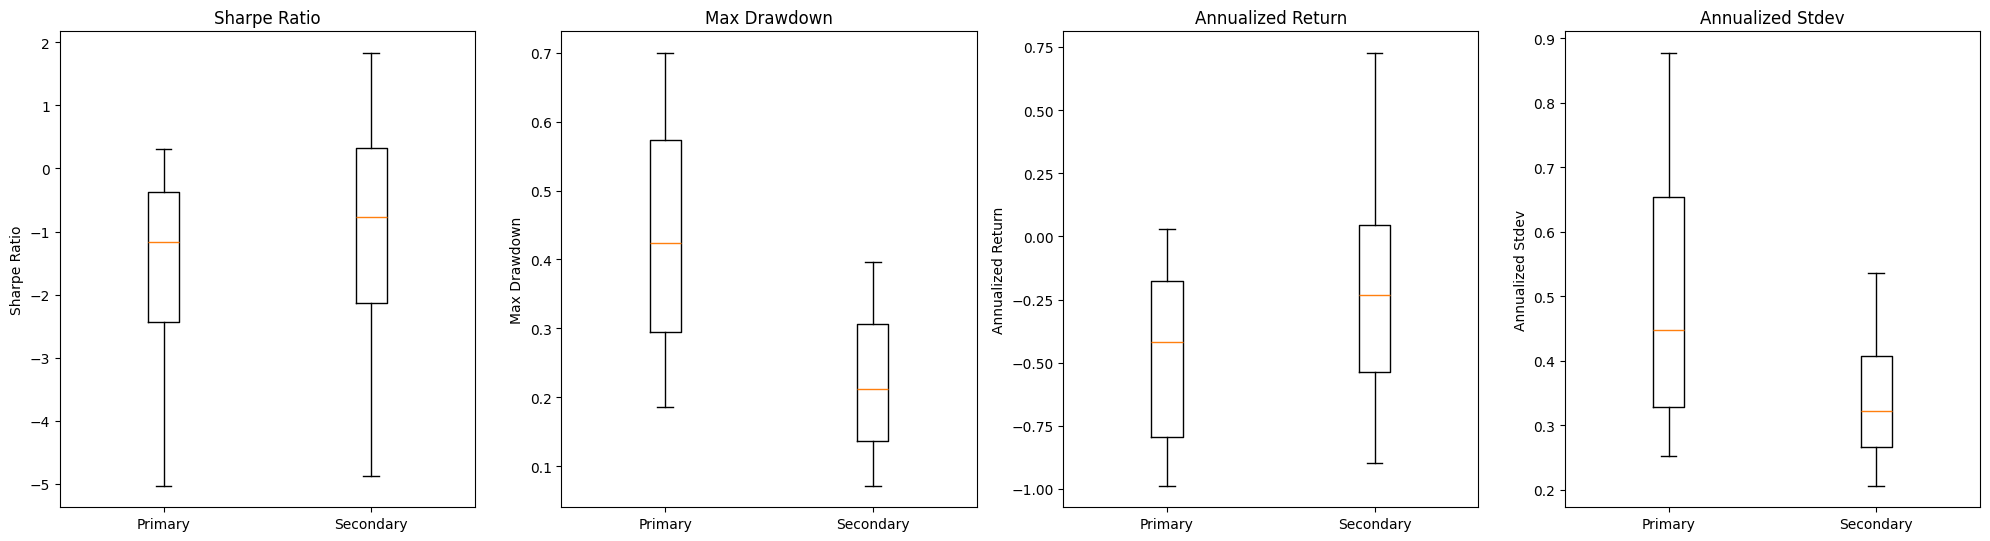

In [271]:


fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.boxplot([metrics_primary[metric], metrics_secondary[metric]], labels=['Primary', 'Secondary'])
    ax.set_title(metric)
    ax.set_ylabel(metric)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


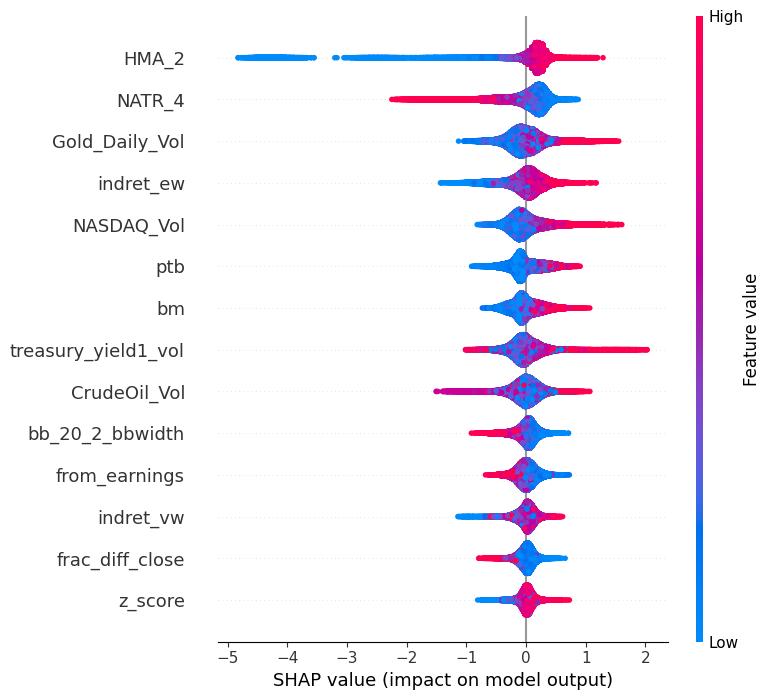

In [272]:
# Create SHAP explainer
explainer = shap.TreeExplainer(trained_clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot for the first class (if binary classification)
shap.summary_plot(shap_values[1], X_train)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_train.iloc[0])


# Test

In [273]:
# Results Primary

primary_forecast = pd.DataFrame(y_test)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18667
           1       0.45      1.00      0.62     15364

    accuracy                           0.45     34031
   macro avg       0.23      0.50      0.31     34031
weighted avg       0.20      0.45      0.28     34031

Confusion Matrix
[[    0 18667]
 [    0 15364]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [274]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_test)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_test, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_test, y_pred))

Confusion Matrix for Direct Predictions:
[[ 9787  8880]
 [ 4609 10755]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.68      0.52      0.59     18667
           1       0.55      0.70      0.61     15364

    accuracy                           0.60     34031
   macro avg       0.61      0.61      0.60     34031
weighted avg       0.62      0.60      0.60     34031



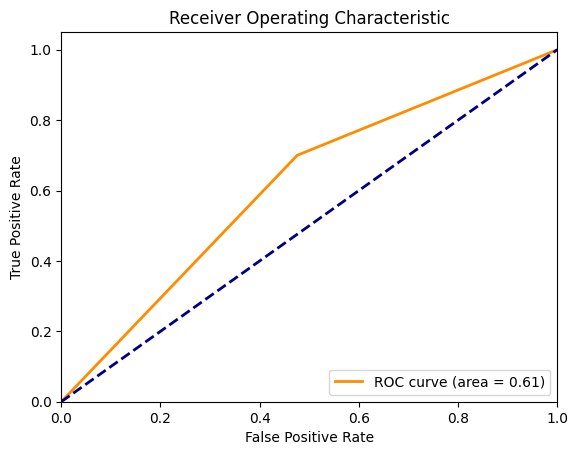

In [275]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [276]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.6).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_test, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[11941  6726]
 [ 6853  8511]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64     18667
           1       0.56      0.55      0.56     15364

    accuracy                           0.60     34031
   macro avg       0.60      0.60      0.60     34031
weighted avg       0.60      0.60      0.60     34031



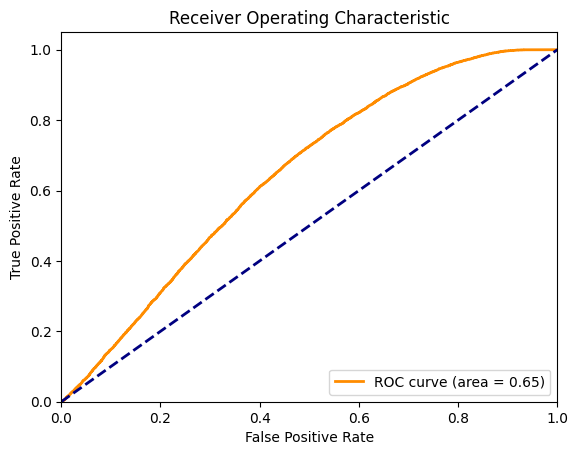

In [277]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [278]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.9 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.9).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.9 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.9 Threshold:")
print(classification_report(y_test, y_pred_threshold))

Confusion Matrix with 0.9 Threshold:
[[17981   686]
 [14629   735]]

Classification Report with 0.9 Threshold:
              precision    recall  f1-score   support

           0       0.55      0.96      0.70     18667
           1       0.52      0.05      0.09     15364

    accuracy                           0.55     34031
   macro avg       0.53      0.51      0.39     34031
weighted avg       0.54      0.55      0.42     34031



Model Performance Changes
      Metric  Primary Model  Secondary Model  Change (%)
0  Precision         0.4515           0.5586     23.7233
1     Recall         1.0000           0.5540    -44.6043
2   F1-Score         0.6221           0.5563    -10.5823
3   Accuracy         0.4515           0.6010     33.1164
4        AUC         0.5000           0.6455     29.1097


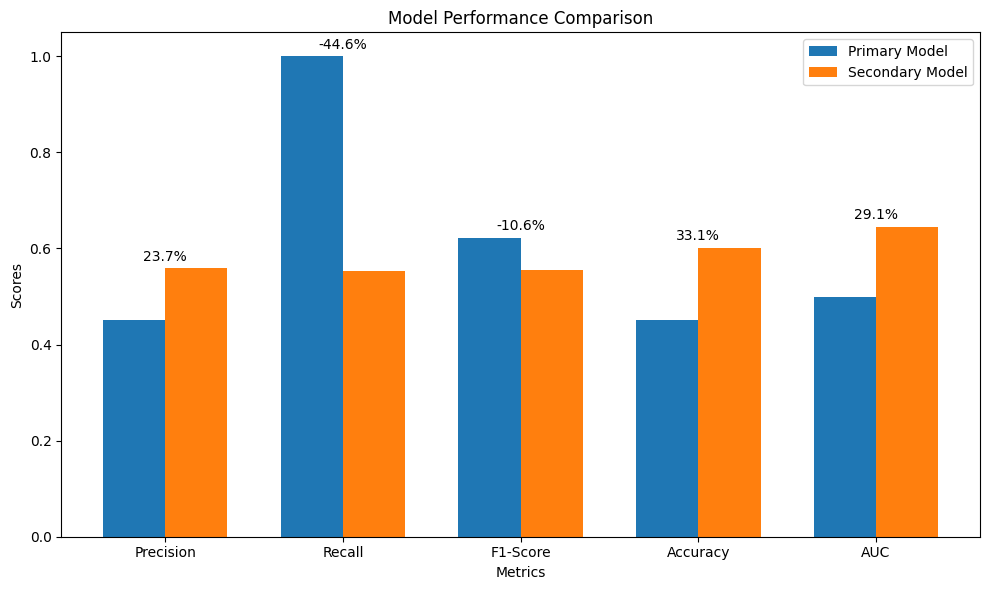

In [279]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

primary_forecast = pd.DataFrame(y_test)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Secondary model predictions
# Assuming clf and X_test are defined elsewhere
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred_threshold = (y_pred_proba >= 0.6).astype(int)

# Calculate performance metrics for primary model
precision_primary, recall_primary, f1_primary, _ = precision_recall_fscore_support(primary_forecast['actual'], primary_forecast['pred'], average=None, labels=[1])
accuracy_primary = accuracy_score(primary_forecast['actual'], primary_forecast['pred'])
# For the primary model, since the prediction is always 1, the AUC is not applicable
auc_primary = roc_auc_score(primary_forecast['actual'], primary_forecast['pred'])

# Calculate performance metrics for secondary model
precision_secondary, recall_secondary, f1_secondary, _ = precision_recall_fscore_support(y_test, y_pred_threshold, average=None, labels=[1])
accuracy_secondary = accuracy_score(y_test, y_pred_threshold)
auc_secondary = roc_auc_score(y_test, y_pred_proba)  # Use probabilities for AUC calculation

# Calculate percentage changes
precision_change = ((precision_secondary - precision_primary) / precision_primary) * 100
recall_change = ((recall_secondary - recall_primary) / recall_primary) * 100
f1_change = ((f1_secondary - f1_primary) / f1_primary) * 100
accuracy_change = ((accuracy_secondary - accuracy_primary) / accuracy_primary) * 100
auc_change = ((auc_secondary - auc_primary) / auc_primary) * 100 if auc_primary != 0 else 0

# Create a DataFrame for the changes
changes_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'AUC'],
    'Primary Model': [precision_primary[0], recall_primary[0], f1_primary[0], accuracy_primary, auc_primary],
    'Secondary Model': [precision_secondary[0], recall_secondary[0], f1_secondary[0], accuracy_secondary, auc_secondary],
    'Change (%)': [precision_change[0], recall_change[0], f1_change[0], accuracy_change, auc_change]
})

# Print the DataFrame to the console
print("Model Performance Changes")
print(changes_df)

# Plotting the changes
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(changes_df))

bar1 = ax.bar(index, changes_df['Primary Model'], bar_width, label='Primary Model')
bar2 = ax.bar(index + bar_width, changes_df['Secondary Model'], bar_width, label='Secondary Model')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(changes_df['Metric'])
ax.legend()

# Adding percentage change annotations
for i in range(len(changes_df)):
    ax.text(i + bar_width / 2, max(changes_df['Primary Model'][i], changes_df['Secondary Model'][i]) + 0.01,
            f"{changes_df['Change (%)'][i]:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [280]:
X_test

,indret_vw,ptb,frac_diff_close,CrudeOil_Vol,bm,indret_ew,NASDAQ_Vol,HMA_2,z_score,NATR_4,from_earnings,Gold_Daily_Vol,treasury_yield1_vol,bb_20_2_bbwidth
82771,-0.0262,2.3790,0.9619,0.0800,0.5140,-0.0374,0.0219,-0.0390,-2.5427,3.2932,37.0000,0.0212,0.2162,0.0738
82772,-0.0158,0.0000,11.0800,0.0800,0.0000,-0.0105,0.0219,-0.0461,-6.4911,2.1339,41.0000,0.0212,0.2162,0.0685
82773,-0.0040,5.7960,1.5377,0.0800,0.1710,-0.0347,0.0219,-0.0172,-3.8865,1.1724,48.0000,0.0212,0.2162,0.0191
82774,-0.0158,3.0240,3.6323,0.0800,0.3820,-0.0105,0.0219,-0.0651,-8.7056,3.6832,42.0000,0.0212,0.2162,0.0586
82775,-0.0257,6.7940,-0.5511,0.0800,0.1030,0.0446,0.0219,-0.0886,-5.3284,4.4682,41.0000,0.0212,0.2162,0.0799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116797,0.0773,9.2350,-5.1750,0.1246,0.0970,0.1073,0.0323,-0.1426,-8.5976,5.9835,49.0000,0.0467,0.7235,0.1786
116798,0.0742,0.0000,1.7280,0.1246,0.0000,0.1430,0.0323,-0.0211,-3.5295,1.2022,35.0000,0.0467,0.7235,0.0253
116799,0.0649,9.5810,5.2189,0.1246,0.1350,0.1221,0.0323,-0.0081,-2.3697,1.8220,43.0000,0.0467,0.7235,0.0679
116800,0.0803,3.6680,1.8576,0.1246,0.2690,0.1002,0.0323,-0.0167,-4.0661,1.2572,44.0000,0.0467,0.7235,0.0376


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


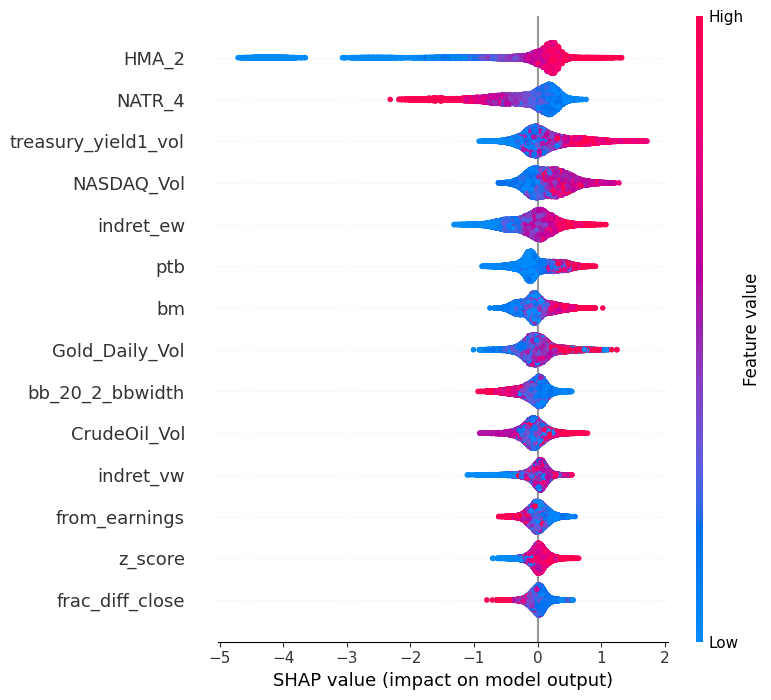

In [281]:
# Create SHAP explainer
explainer = shap.TreeExplainer(clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot for the first class (if binary classification)
shap.summary_plot(shap_values[1], X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


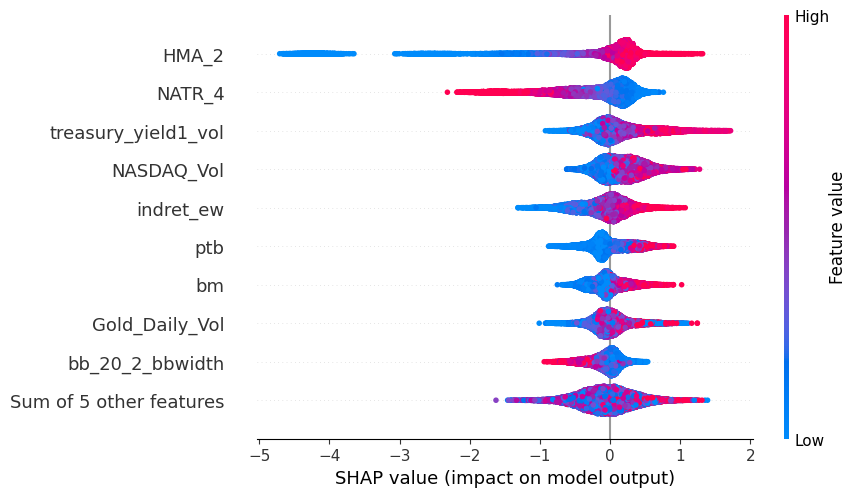

In [282]:
from shap import Explanation

# Assuming you have already calculated shap_values and explainer
shap_values_class_1 = shap_values[1]  # For class 1 in binary classification

# Wrap SHAP values in an Explanation object
explanation = Explanation(values=shap_values_class_1, base_values=explainer.expected_value[1], data=X_test, feature_names=X_test.columns)

# Plot the beeswarm
shap.plots.beeswarm(explanation)

In [283]:
shap_values_class1 = shap_values[1]

shap_df = pd.DataFrame(shap_values_class1, columns=X_test.columns)
feature_df = X_test.reset_index(drop=True)

# Calculate the correlation between each feature value and its corresponding SHAP value
correlations = {}

for column in feature_df.columns:
    corr = np.corrcoef(feature_df[column], shap_df[column])[0, 1]
    correlations[column] = corr

# Convert correlations to a DataFrame for better readability
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])

# Sort by absolute value of correlation
correlation_df = correlation_df.reindex(correlation_df['Correlation'].abs().sort_values(ascending=False).index)

# Display the correlation summary
print(correlation_df)

                Feature  Correlation
5             indret_ew       0.8229
7                 HMA_2       0.7861
13      bb_20_2_bbwidth      -0.7510
12  treasury_yield1_vol       0.7396
9                NATR_4      -0.6325
4                    bm       0.6007
6            NASDAQ_Vol       0.5689
10        from_earnings      -0.5654
1                   ptb       0.5649
11       Gold_Daily_Vol       0.4787
0             indret_vw       0.2792
3          CrudeOil_Vol       0.2185
2       frac_diff_close      -0.0381
8               z_score       0.0052


In [284]:
import numpy as np
import pandas as pd

# Assuming SHAP values are already calculated
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for the positive class (class 1)
shap_values_class1 = shap_values[1]

# Create a DataFrame with SHAP values and feature values
shap_df = pd.DataFrame(shap_values_class1, columns=X_test.columns)
feature_df = X_test.reset_index(drop=True)

# Define the percentiles
percentiles = [0.25, 0.5, 0.75, 1.0]

# Initialize a dictionary to store the results
percentile_shap_values = {}

# Calculate the average SHAP value at each percentile for each feature
for column in feature_df.columns:
    feature_percentiles = np.percentile(feature_df[column], [p*100 for p in percentiles])
    
    # Initialize a list to hold the mean SHAP values at each percentile
    shap_means = []
    
    for i in range(len(percentiles)):
        if i == 0:
            # Calculate mean SHAP value for feature values less than or equal to the first percentile
            shap_mean = shap_df[column][feature_df[column] <= feature_percentiles[i]].mean()
        else:
            # Calculate mean SHAP value for feature values between the current and previous percentiles
            shap_mean = shap_df[column][(feature_df[column] > feature_percentiles[i-1]) & (feature_df[column] <= feature_percentiles[i])].mean()
        
        shap_means.append(shap_mean)
    
    # Store the results
    percentile_shap_values[column] = shap_means

# Convert the dictionary to a DataFrame for better readability
shap_percentile_df = pd.DataFrame(percentile_shap_values, index=[f'{int(p*100)}th Percentile' for p in percentiles])

# Display the SHAP percentile summary
print(shap_percentile_df)


                  indret_vw     ptb  frac_diff_close  CrudeOil_Vol      bm  \
25th Percentile     -0.0714 -0.1374           0.0908       -0.0172 -0.0509   
50th Percentile      0.0098 -0.2312           0.0228       -0.0874 -0.2849   
75th Percentile      0.0480  0.0604          -0.0100       -0.1323 -0.0423   
100th Percentile    -0.0007  0.3570          -0.0987        0.0010  0.2381   

                  indret_ew  NASDAQ_Vol   HMA_2  z_score  NATR_4  \
25th Percentile     -0.4865     -0.1250 -1.0510  -0.0942  0.2352   
50th Percentile     -0.1107      0.0757  0.0655  -0.0083  0.1319   
75th Percentile      0.0302      0.3971  0.2449   0.0652 -0.2010   
100th Percentile     0.2518      0.3402  0.2721   0.0929 -0.9223   

                  from_earnings  Gold_Daily_Vol  treasury_yield1_vol  \
25th Percentile          0.1054         -0.0751              -0.1797   
50th Percentile          0.0321         -0.0816              -0.0133   
75th Percentile         -0.0182         -0.0075     

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [285]:
shap_percentile_df.to_csv('../data/shap_percentile.csv', index=False)


In [286]:
print(shap_percentile_df)

                  indret_vw     ptb  frac_diff_close  CrudeOil_Vol      bm  \
25th Percentile     -0.0714 -0.1374           0.0908       -0.0172 -0.0509   
50th Percentile      0.0098 -0.2312           0.0228       -0.0874 -0.2849   
75th Percentile      0.0480  0.0604          -0.0100       -0.1323 -0.0423   
100th Percentile    -0.0007  0.3570          -0.0987        0.0010  0.2381   

                  indret_ew  NASDAQ_Vol   HMA_2  z_score  NATR_4  \
25th Percentile     -0.4865     -0.1250 -1.0510  -0.0942  0.2352   
50th Percentile     -0.1107      0.0757  0.0655  -0.0083  0.1319   
75th Percentile      0.0302      0.3971  0.2449   0.0652 -0.2010   
100th Percentile     0.2518      0.3402  0.2721   0.0929 -0.9223   

                  from_earnings  Gold_Daily_Vol  treasury_yield1_vol  \
25th Percentile          0.1054         -0.0751              -0.1797   
50th Percentile          0.0321         -0.0816              -0.0133   
75th Percentile         -0.0182         -0.0075     

### Financial


In [287]:
test_set

,date,open,high,low,close,volume,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,gvkey,gsector,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,PSAR_0.02_0.2
82771,2020-01-02 00:00:00+00:00,33.2500,33.3700,31.5400,32.2700,841224.0000,37.0000,27.0000,33.5752,34.8137,32.3368,-0.0270,0.0738,21706.5130,3.6000,1.8000,15452.4000,6945.0100,3257.8501,0.0183,9092.1904,0.0219,28868.8008,0.0203,1524.5000,0.0212,17.9660,0.0478,61.1800,0.0800,6985.4702,96.8500,1.8820,1.4950,1.6710,2.3410,0.8460,1.8367,0.2162,1.0000,0.0000,-0.5355,3.2932,32.8170,32.5115,32.3914,45.8762,6.7500,48.2091,29.1367,11.0821,41.6997,22.4622,14.0992,37.7583,1.0627,-0.9900,33.4041,0.0200,1.0000,-2.9765,19.4428,31.3514,-163.9097,0.0000,32.9051,20.1335,19.1725,100.0000,42.8571,-57.1429,-0.0390,-0.0144,-0.0097,32.0590,33.0025,33.9460,5.7180,0.1118,0.5787,0.0133,0.0237,0.0172,0.0180,0.0158,0.0133,-0.0895,-0.0274,0.0093,0.4501,0.0058,0.0144,-2.5427,11.6219,0.9619,0.0542,1.0000,11854.0000,40.0000,14318.0000,55.5930,0.5140,8.1490,13.5830,14.4430,14.4430,14.4430,6.2320,11.7260,0.0000,0.4490,0.6350,0.6100,0.6350,0.5690,0.4770,0.1970,0.2120,0.2520,0.2060,0.2150,0.1900,0.2150,0.0000,0.0000,0.1870,0.8370,0.1630,0.1570,0.1630,0.0800,0.0830,0.2910,0.0000,0.0000,0.1230,0.6600,0.0100,0.0000,0.3760,0.0000,0.0000,0.3730,0.9450,13.0930,0.1890,0.3410,0.1870,0.5170,13.9570,17.6070,0.0000,0.0000,0.0000,0.0000,0.0000,0.2940,6.9120,4.5720,0.3740,0.4460,0.0000,0.0000,0.0000,0

In [288]:
ypred = trained_clf.predict_proba(X_test)[:,1]
column_names = test_set.columns.to_list()
column_names.append("pred")
test_set_with_preds = pd.DataFrame(data = np.c_[test_set.to_numpy(), ypred])
test_set_with_preds.columns = column_names


In [289]:
# profit factor whole dataset
print("Test set base PF:")
print(sum(test_set_with_preds[test_set_with_preds["profit"] > 0]["profit"]) / abs(sum(test_set_with_preds[test_set_with_preds["profit"] <= 0]["profit"])))
print("")

# profit factor with model predictions
print("Test set with > 0.5 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.5]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

print("Test set with > 0.8 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.8]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

print("Test set with > 0.9 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.9]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

Test set base PF:
0.6425398477746339

Test set with > 0.5 PF:
0.8762624890292519

Test set with > 0.8 PF:
0.7903252574953046

Test set with > 0.9 PF:
0.5912551954024783



In [290]:
len(test_set_with_preds)

34031

In [291]:
test_set_with_preds

,date,open,high,low,close,volume,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,gvkey,gsector,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,PSAR_0.02_0.2,pred
0,2020-01-02 00:00:00+00:00,33.2500,33.3700,31.5400,32.2700,841224.0000,37.0000,27.0000,33.5752,34.8137,32.3368,-0.0270,0.0738,21706.5130,3.6000,1.8000,15452.4000,6945.0100,3257.8501,0.0183,9092.1904,0.0219,28868.8008,0.0203,1524.5000,0.0212,17.9660,0.0478,61.1800,0.0800,6985.4702,96.8500,1.8820,1.4950,1.6710,2.3410,0.8460,1.8367,0.2162,1.0000,0.0000,-0.5355,3.2932,32.8170,32.5115,32.3914,45.8762,6.7500,48.2091,29.1367,11.0821,41.6997,22.4622,14.0992,37.7583,1.0627,-0.9900,33.4041,0.0200,1.0000,-2.9765,19.4428,31.3514,-163.9097,0.0000,32.9051,20.1335,19.1725,100.0000,42.8571,-57.1429,-0.0390,-0.0144,-0.0097,32.0590,33.0025,33.9460,5.7180,0.1118,0.5787,0.0133,0.0237,0.0172,0.0180,0.0158,0.0133,-0.0895,-0.0274,0.0093,0.4501,0.0058,0.0144,-2.5427,11.6219,0.9619,0.0542,1.0000,11854.0000,40.0000,14318.0000,55.5930,0.5140,8.1490,13.5830,14.4430,14.4430,14.4430,6.2320,11.7260,0.0000,0.4490,0.6350,0.6100,0.6350,0.5690,0.4770,0.1970,0.2120,0.2520,0.2060,0.2150,0.1900,0.2150,0.0000,0.0000,0.1870,0.8370,0.1630,0.1570,0.1630,0.0800,0.0830,0.2910,0.0000,0.0000,0.1230,0.6600,0.0100,0.0000,0.3760,0.0000,0.0000,0.3730,0.9450,13.0930,0.1890,0.3410,0.1870,0.5170,13.9570,17.6070,0.0000,0.0000,0.0000,0.0000,0.0000,0.2940,6.9120,4.5720,0.3740,0.4460,0.0000,0.0000,0.0000,

In [292]:
import numpy as np
import pandas as pd

ypred = trained_clf.predict_proba(X_test)[:,1]
column_names = test_set.columns.to_list()
column_names.append("pred")
test_set_with_preds = pd.DataFrame(data = np.c_[test_set.to_numpy(), ypred])
test_set_with_preds.columns = column_names

# Assuming `test_set_with_preds` DataFrame is already created as shown in your context

# Primary Model: Predictions are all 1
primary_model_profits = test_set_with_preds["profit"]

# Secondary Model: Predictions with a threshold of 0.6
secondary_model_profits = test_set_with_preds[test_set_with_preds["pred"] > 0.7]["profit"]

# Calculate mean and standard deviation for primary model
primary_mean_profit = primary_model_profits.mean()
primary_std_profit = primary_model_profits.std()

# Calculate mean and standard deviation for secondary model
secondary_mean_profit = secondary_model_profits.mean()
secondary_std_profit = secondary_model_profits.std()

# Calculate the differences
mean_profit_difference = secondary_mean_profit - primary_mean_profit
std_profit_difference = secondary_std_profit - primary_std_profit

# Print the results
print("Mean Profit Difference (Secondary - Primary):", mean_profit_difference)
print("Standard Deviation of Profit Difference (Secondary - Primary):", std_profit_difference)


Mean Profit Difference (Secondary - Primary): 0.020308451247206698
Standard Deviation of Profit Difference (Secondary - Primary): -0.023564658545003725


In [293]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Define function to calculate daily returns
def calculate_daily_returns(prices):
    return prices['prccd'].pct_change().fillna(0)

# Define function to calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    if len(returns) > 1:  # Ensure there are enough returns to calculate statistics
        excess_returns = returns - risk_free_rate
        return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    else:
        return np.nan  # Return NaN if not enough data

# Define function to calculate maximum drawdown
def calculate_max_drawdown(returns):
    if len(returns) > 1:
        cumulative_returns = (1 + returns).cumprod()
        running_max = cumulative_returns.cummax()
        drawdowns = (running_max - cumulative_returns) / running_max
        return drawdowns.max()
    else:
        return np.nan

# Define function to calculate annualized returns
def calculate_annualized_returns(returns):
    if len(returns) > 1:
        cumulative_return = (1 + returns).prod()
        return cumulative_return ** (252 / len(returns)) - 1
    else:
        return np.nan

# Define function to calculate annualized standard deviation
def calculate_annualized_stdev(returns):
    if len(returns) > 1:
        return np.std(returns) * np.sqrt(252)
    else:
        return np.nan

# Merge test_set_with_preds with raw to include 'cusip' and 'exit_date'
merged_trades = pd.merge(
    test_set_with_preds,
    raw[['date', 'exit_date', 'gvkey', 'cusip']],
    on=['date', 'gvkey'],
    how='left'
)

# Determine the overall date range from the entire test_set_with_preds
overall_start_date = merged_trades['date'].min()
overall_end_date = merged_trades['exit_date'].max()

# Initialize lists to store the metrics for boxplots
metrics_primary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}
metrics_secondary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}

# Iterate over each asset in the merged trades
for asset, group in merged_trades.groupby(['gvkey', 'cusip']):
    cusip = group['cusip'].iloc[0]

    # Load daily price data for the asset
    price_data_path = f"data/trading_daily/{cusip}.csv"
    if os.path.exists(price_data_path):
        price_data = pd.read_csv(price_data_path, parse_dates=['datadate'])
        price_data.set_index('datadate', inplace=True)

        # Calculate daily returns
        price_data['daily_return'] = calculate_daily_returns(price_data)

        # Filter trade periods beforehand for the primary strategy
        primary_trade_dates = pd.DatetimeIndex([])
        for _, trade in group.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            primary_trade_dates = primary_trade_dates.append(trade_dates)

        # Filtered returns for primary strategy
        primary_trade_returns = price_data.loc[primary_trade_dates, 'daily_return']

        # Calculate metrics for the primary strategy if trades occurred
        if not primary_trade_returns.empty:
            metrics_primary['Sharpe Ratio'].append(calculate_sharpe_ratio(primary_trade_returns))
            metrics_primary['Max Drawdown'].append(calculate_max_drawdown(primary_trade_returns))
            metrics_primary['Annualized Return'].append(calculate_annualized_returns(primary_trade_returns))
            metrics_primary['Annualized Stdev'].append(calculate_annualized_stdev(primary_trade_returns))

        # Filter trade periods beforehand for the secondary strategy
        secondary_trades = group[group['pred'] > 0.6]
        secondary_trade_dates = pd.DatetimeIndex([])
        for _, trade in secondary_trades.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            secondary_trade_dates = secondary_trade_dates.append(trade_dates)

        # Filtered returns for secondary strategy
        secondary_trade_returns = price_data.loc[secondary_trade_dates, 'daily_return']

        # Calculate metrics for the secondary strategy if trades occurred
        if not secondary_trade_returns.empty:
            metrics_secondary['Sharpe Ratio'].append(calculate_sharpe_ratio(secondary_trade_returns))
            metrics_secondary['Max Drawdown'].append(calculate_max_drawdown(secondary_trade_returns))
            metrics_secondary['Annualized Return'].append(calculate_annualized_returns(secondary_trade_returns))
            metrics_secondary['Annualized Stdev'].append(calculate_annualized_stdev(secondary_trade_returns))

# Convert NaN values to 0 for plotting
for metric in metrics_primary:
    metrics_primary[metric] = np.nan_to_num(metrics_primary[metric], nan=0.0)

for metric in metrics_secondary:
    metrics_secondary[metric] = np.nan_to_num(metrics_secondary[metric], nan=0.0)

# Plotting boxplots for each metric
metrics = ['Sharpe Ratio', 'Max Drawdown', 'Annualized Return', 'Annualized Stdev']




In [294]:
def winsorize(series, lower_quantile=0.10, upper_quantile=0.90):
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower=lower_bound, upper=upper_bound)

# Apply Winsorization
for metric in metrics_primary:
    metrics_primary[metric] = winsorize(pd.Series(metrics_primary[metric]))
for metric in metrics_secondary:
    metrics_secondary[metric] = winsorize(pd.Series(metrics_secondary[metric]))


# Convert the metrics dictionaries to DataFrames
primary_metrics_df = pd.DataFrame(metrics_primary)
secondary_metrics_df = pd.DataFrame(metrics_secondary)

# Output descriptive statistics
print("Primary Metrics Descriptive Statistics:")
print(primary_metrics_df.describe())

print("\nSecondary Metrics Descriptive Statistics:")
print(secondary_metrics_df.describe())

Primary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     3975.0000     3975.0000          3975.0000         3975.0000
mean        -1.6072        0.4334            -0.4663            0.5012
std          1.6382        0.1670             0.3446            0.2039
min         -5.0316        0.1862            -0.9868            0.2527
25%         -2.4323        0.2945            -0.7944            0.3278
50%         -1.1629        0.4240            -0.4175            0.4483
75%         -0.3790        0.5727            -0.1777            0.6547
max          0.3058        0.6997             0.0302            0.8775

Secondary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     3333.0000     3333.0000          3333.0000         3333.0000
mean        -0.8245        0.2466            -0.1561            0.3954
std          1.8024        0.1086             0.5337            0

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


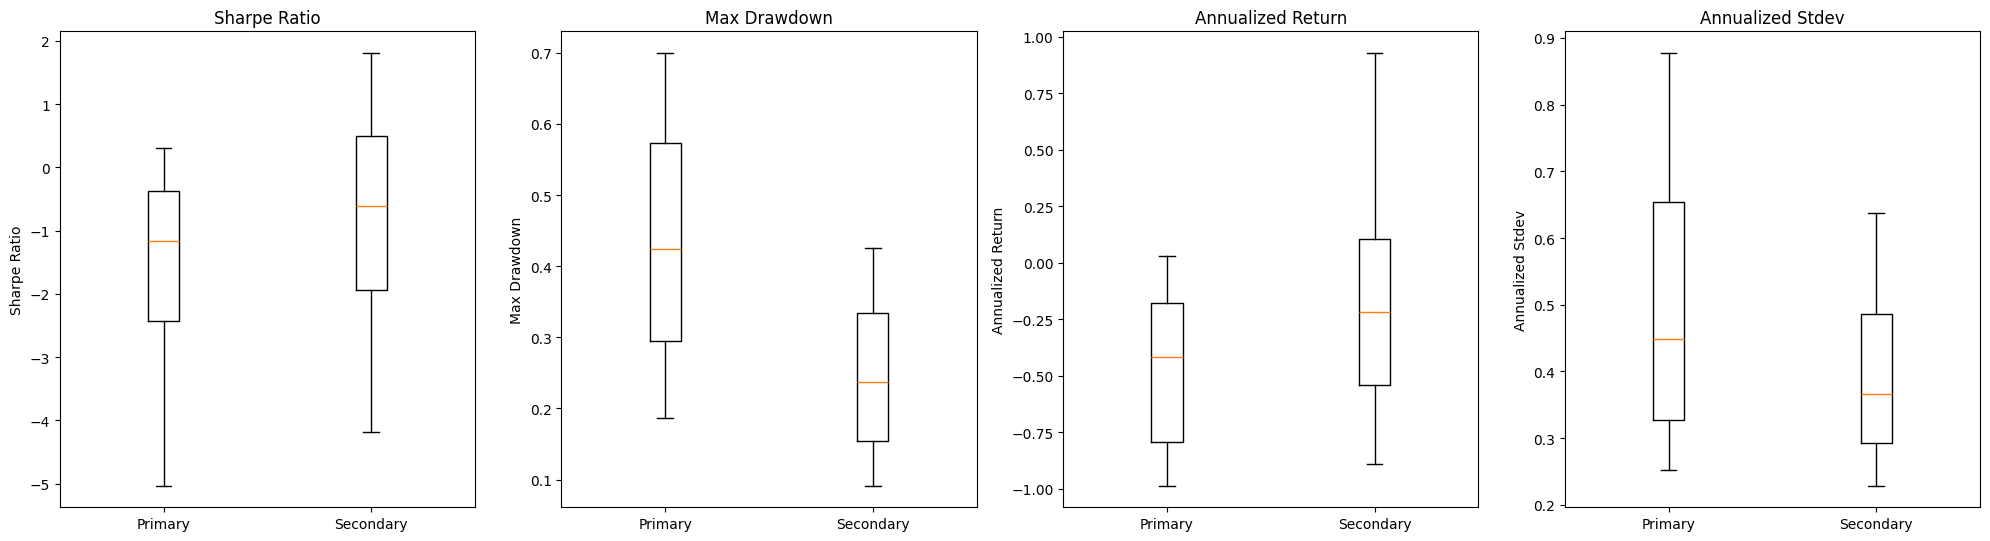

In [295]:


fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.boxplot([metrics_primary[metric], metrics_secondary[metric]], labels=['Primary', 'Secondary'])
    ax.set_title(metric)
    ax.set_ylabel(metric)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [2]:
import graphviz

# Initialize the graph
g = graphviz.Digraph()

# Define the nodes
nodes = [
    "HMA_2", "NATR_4", "Gold", "NASDAQ_Vol", "STDEV_1", 
    "Treasury_Yield4", "Treasury_yield_1_vol", "Silver", 
    "Z_score", "USDIndex", "frac_diff_close", "garch_vol_close", 
    "Gold_Daily_Vol", "indret_vw", "ptb", "bm", "indret_ew", 
    "bb_20_2_bbwidth"
]

# Add nodes to the graph
for node in nodes:
    g.node(node, fontsize="10")

# Add derived or underlying causal nodes
g.node("Market Sentiment", style="dashed", fontsize="10")
g.node("Global Economic Conditions", style="dashed", fontsize="10")
g.node("Interest Rate Expectations", style="dashed", fontsize="10")
g.node("Trade Profitability", style="filled", fontsize="10")

# Define the edges based on causal relationships and SHAP data
g.edge("HMA_2", "Trade Profitability")
g.edge("NATR_4", "Trade Profitability", label="(-)")
g.edge("Gold", "Trade Profitability", label="(-)")
g.edge("NASDAQ_Vol", "Trade Profitability", label="(+)")
g.edge("STDEV_1", "Trade Profitability", label="(-)")
g.edge("Treasury_Yield4", "Trade Profitability", label="(-)")
g.edge("Treasury_yield_1_vol", "Trade Profitability", label="(+)")
g.edge("Silver", "Trade Profitability", label="(+)")
g.edge("Z_score", "Trade Profitability")
g.edge("frac_diff_close", "Trade Profitability", label="(-/+) complex")
g.edge("garch_vol_close", "Trade Profitability", label="(-)")
g.edge("Gold_Daily_Vol", "Trade Profitability", label="(+)")
g.edge("indret_vw", "Trade Profitability", label="(+)")
g.edge("ptb", "Trade Profitability", label="(-/+) complex")
g.edge("bm", "Trade Profitability", label="(+)")
g.edge("indret_ew", "Trade Profitability", label="(+)")

# Connect broader factors to features
g.edge("Market Sentiment", "Gold")
g.edge("Market Sentiment", "Silver")
g.edge("Market Sentiment", "USDIndex")
g.edge("Market Sentiment", "NASDAQ_Vol")
g.edge("Global Economic Conditions", "Treasury_Yield4")
g.edge("Global Economic Conditions", "Treasury_yield_1_vol")
g.edge("Global Economic Conditions", "Interest Rate Expectations")
g.edge("Interest Rate Expectations", "Treasury_Yield4")
g.edge("Interest Rate Expectations", "Treasury_yield_1_vol")
g.edge("Market Sentiment", "HMA_2")

# Influence of Economic Conditions and Market Sentiment on Volatility
g.edge("Global Economic Conditions", "STDEV_1")
g.edge("Market Sentiment", "garch_vol_close")

# Influence of broader factors on Market Sentiment and Profitability
g.edge("Global Economic Conditions", "Market Sentiment")
g.edge("Market Sentiment", "Trade Profitability", label="(Indirect)")

# Display the graph
g.render('causal_flow_diagram', format='png', view=True)


'causal_flow_diagram.png'

In [296]:
def save_model_sklearn(model_name: str):
    """
    Saves models from sklearn to filesystem.

    Args:
        model (sklearn model): Sklearn model.
        path (string): The path to save the model to.
        model_name (string): The name of the model.
    """
    joblib.dump(trained_clf, f'../data/processed/stockscreener/ml_model/{model_name}.joblib')